In [15]:
from scripts.imports import os, glob, pdb, np, h5py, pd, xr, gpd, Proj, Transformer, CRS, \
                        plt, cmap, cmap2, Model, Data, ODR, datetime, rasterio, show, \
                        ccrs, cfeature
from scripts.classes_fixed import *
from scripts.show_tracks import *
from scripts.parallel import *
from scripts.track_pairs import *
import geopandas as gpd
from shapely.geometry import Point, box as shapely_box
from scipy.optimize import least_squares
from sklearn.metrics import r2_score, mean_squared_error
from scripts.odr import *

def parse_filename_datetime(filename):
    # Extracting only the filename from the full path
    filename_only = filename.split('/')[-1]
    
    # Finding the index of the first appearance of 'ATL03_' or 'ATL08_'
    atl03_index = filename_only.find('ATL03_')
    atl08_index = filename_only.find('ATL08_')
    
    # Determining the split index based on which string appears first or if neither is found
    split_index = min(filter(lambda x: x >= 0, [atl03_index, atl08_index]))

    # Extracting yyyymmddhhmmss part
    date_str = filename_only[split_index + 6:split_index + 20]
    
    datetime_obj = datetime.strptime(date_str, '%Y%m%d%H%M%S')
    return datetime_obj

def datetime_to_title(datetime_obj):
    return datetime_obj.strftime('%B %d, %Y, %H:%M:%S')

def make_box(coords, width=2, height=2):
    w = width
    h = height
    polygon = gpd.GeoDataFrame(geometry=[shapely_box(coords[0]-w, coords[1]-h, coords[0]+w, coords[1]+h)], crs="EPSG:4326")

    return polygon

# This function is called if the graph_detail is set to 2!
# I know I used different coding structure for this one but
# all I can really say is whoops and move on.
def plot_parallel(atl03s, coefs, colors, title_date, X, Y, beam = None, canopy_frac = None, terrain_frac = None, file_index=None, three=None):
    """
    Plotting function of pvpg_parallel. Shows a regression line for each available groudntrack in a bigger plot, as well as groundtrack visualisations in a smaller plot.
    
    atl03s - This is an array of ATL03 objects, one for each groundtrack that was successfully turned into an object. If only Beams 5 and 6 exist, then this has two objects in it, one for each of those beams.
    coefs - Array of parameters that are optimized, starting with the slope in coefs[0] and another parameter for each beam to control the y-intercept.
    colors - This holds the integers minus one of the beams that have groundtracks in the file. This is to keep the coloring in the plots consistent for each beam across all files.
    title_date - This is just the data and time of the ICESat-2 overpass. The parse_filename_datetime() function will take care of this for you.
    X - Array of each Eg dataset, [[data1],[data2],...]. This always has six arrays in it, one for each groundtrack from Beam 1 to Beam 6. If nothing is read, you get an empty array [], e.g. [[data1],[],[data3],...]
    Y - Array of each Ev dataset, see X description.
    beam - An array of beams to focus on. For example, if you only want to see pv/pg information on the plot for Beams 3 and 4, then you would set beam = [3,4]. Default is None, and all beams are shown.
    file_index - Default set to None. If changed, this will show the index of the file in an array of all ATL03 file paths so that it is easy to find and focus on interesting cases. Works if you are in a loop of filepaths and you need to know which one is being funky.
    canopy_frac - Default is None. If changed, this will say in the title of the groundtrack what percentage of the data has canopy photon data. Low canopy fraction could indicate poor quality data. This is only displayed if Detail = 2.
    """
    # Simple array of all the beam names
    beam_names = [f"Beam {i}" for i in range(1,7)]
    
    # Six small figures for groundtracks and one for the pv/pg plot
    fig = plt.figure(figsize=(10, 12))
    if three == None:
        ax1 = fig.add_subplot(331)
        ax2 = fig.add_subplot(332)
        ax3 = fig.add_subplot(334)
        ax4 = fig.add_subplot(335)
        ax5 = fig.add_subplot(337)
        ax6 = fig.add_subplot(338)
        ax7 = fig.add_subplot(133)
    else:
        ax1 = fig.add_subplot(321)
        ax2 = fig.add_subplot(322)
        ax3 = fig.add_subplot(323)
        ax4 = fig.add_subplot(324)
        ax5 = fig.add_subplot(325)
        ax6 = fig.add_subplot(326)
    axes = [ax1, ax2, ax3, ax4, ax5, ax6]
    
    # Set the figure title
    if file_index != None:
        fig.suptitle(title_date + ' - N = ' + str(file_index), fontsize=16)
    else:
        fig.suptitle(title_date, fontsize=16)
    
    # we go through each color and atl03 object together.
    # In this loop, we plot all of the groundtracks where they belong
    # depending on which beam it is and plot the data in the scatterplot
    for i, c, atl03 in zip(np.arange(len(colors)),colors, atl03s):
        
        # If there's a canopy fraction wanted, we stick it in the title
        if (canopy_frac != None) & (terrain_frac != None):
            atl03.plot_small(axes[c], f"{beam_names[c]} - TF = {round(terrain_frac[c],2)}, CF = {round(canopy_frac[c],2)}")
        
        elif canopy_frac != None:
            atl03.plot_small(axes[c], f"{beam_names[c]} - CF = {round(canopy_frac[c],2)}")
        
        elif terrain_frac != None:
            atl03.plot_small(axes[c], f"{beam_names[c]} - TF = {round(terrain_frac[c],2)}")
        
        else:
            atl03.plot_small(axes[c], beam_names[c])
        
        # If there's a focus on certain beams, we run this if statement to
        # check if the current beam is in the list of beams the user wants.
        # Then we throw the data onto the scatterplot with the color of choice
        # along with a regression line of the same color
        if three == None:
        
            if beam != None:
                if c + 1 in beam:
                    ax7.scatter(X[c],Y[c], s=5, color=cmap2(c))
                    ax7.plot(np.array([0,12]), model([coefs[0], coefs[1+i]], np.array([0,12])), label=f"Beam {int(c+1)}",\
                        color=cmap2(c), linestyle='--', zorder=3)
            else:
                ax7.scatter(X[c],Y[c], s=5, color=cmap2(c))
                ax7.plot(np.array([0,12]), model([coefs[0], coefs[1+i]], np.array([0,12])), label=f"Beam {int(c+1)}",\
                    color=cmap2(c), linestyle='--', zorder=3)
    
    
    if three == None:        
        # Show the pv/pg estimate on the plot
        ax7.annotate(r'$\rho_v/\rho_g \approx {:.2f}$'.format(-coefs[0]),
                       xy=(.35,.98),
                       xycoords='axes fraction',
                       ha='right',
                       va='top',
                       fontsize=8,
                       bbox=dict(boxstyle="round,pad=0.3",
                                 edgecolor="black",
                                 facecolor="white"))
    
        # Set all the boring plot details
        ax7.set_title(f"Ev/Eg Rates", fontsize=8)
        ax7.set_xlabel('Eg (returns/shot)')
        ax7.set_ylabel('Ev (returns/shot)')
        ax7.set_xlim(0,8)
        ax7.set_ylim(0,40)
        ax7.legend(loc='best')
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust the layout to make room for the suptitle
    plt.show()
    return

# This corresponds to graph_detail = 1
def plot_graph(coefs, colors, title_date, X, Y, beam = None, file_index=None):
    """
    Plotting function of pvpg_parallel. Shows a regression line for each available groudntrack in a bigger plot, as well as groundtrack visualisations in a smaller plot.
    
    coefs - Array of parameters that are optimized, starting with the slope in coefs[0] and another parameter for each beam to control the y-intercept.
    colors - This holds the integers minus one of the beams that have groundtracks in the file. This is to keep the coloring in the plots consistent for each beam across all files.
    title_date - This is just the data and time of the ICESat-2 overpass. The parse_filename_datetime() function will take care of this for you.
    X - Array of each Eg dataset, [[data1],[data2],...]. This always has six arrays in it, one for each groundtrack from Beam 1 to Beam 6. If nothing is read, you get an empty array [], e.g. [[data1],[],[data3],...]
    Y - Array of each Ev dataset, see X description.
    beam - An array of beams to focus on. For example, if you only want to see pv/pg information on the plot for Beams 3 and 4, then you would set beam = [3,4]. Default is None, and all beams are shown.
    file_index - Default set to None. If changed, this will show the index of the file in an array of all ATL03 file paths so that it is easy to find and focus on interesting cases. Works if you are in a loop of filepaths and you need to know which one is being funky.
    """
    
    # Big plot that we want
    fig = plt.figure(figsize=(10, 6))
    
    # Set the figure title
    if file_index != None:
        fig.suptitle(title_date + ' - N = ' + str(file_index), fontsize=16)
    else:
        fig.suptitle(title_date, fontsize=16)
    
    # Plot the data and the regression lines. If the beam parameter is active,
    # then only for the beams of interest
    for i, c in enumerate(colors):
        if beam != None:
            if c + 1 in beam:
                # scatter
                plt.scatter(X[c],Y[c], s=5, color=cmap2(c))
                # regress
                plt.plot(np.array([0,12]), model([coefs[0], coefs[1+i]], np.array([0,12])), label=f"Beam {int(c+1)}",\
                    color=cmap2(c), linestyle='--', zorder=3)
        else:
            #scatter
            plt.scatter(X[c],Y[c], s=5, color=cmap2(c))
            #regress
            plt.plot(np.array([0,12]), model([coefs[0], coefs[1+i]], np.array([0,12])), label=f"Beam {int(c+1)}",\
                color=cmap2(c), linestyle='--', zorder=3)
    # Display the pv/pg estimate
    plt.annotate(r'$\rho_v/\rho_g \approx {:.2f}$'.format(-coefs[0]),
                   xy=(.081,.98),
                   xycoords='axes fraction',
                   ha='right',
                   va='top',
                   fontsize=8,
                   bbox=dict(boxstyle="round,pad=0.3",
                             edgecolor="black",
                             facecolor="white"))
    
    # Do all the boring plot display stuff
    plt.title(f"Ev/Eg Rates", fontsize=8)
    plt.xlabel('Eg (returns/shot)')
    plt.ylabel('Ev (returns/shot)')
    plt.xlim(0,8)
    plt.ylim(0,8)
    plt.legend(loc='best')
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust the layout to make room for the suptitle
    plt.show()

def parallel_model(params, x):
    # print(x)
    common_slope, *parallel = params

    # Get all columns starting with 'Beam'
    beam_columns = [col for col in x.columns if col.startswith('Beam')]
    return common_slope*x['Eg'] + np.dot(x[beam_columns], parallel)

def parallel_residuals(params, x, y, model = parallel_model):
    model_output = model(params, x)
    # print(y.T.values[0])
    return (y.T.values[0] - model_output)/np.sqrt(1 + params[0]**2)

def parallel_odr(dataset, maxes, init = -1, lb = -100, ub = -1/100, model = parallel_model, res = parallel_residuals, loss='arctan', f_scale=.1):
    """
    Performs the parallel orthogonal distance regression on the given dataset.
    
    dataset - Pandas Dataframe with columns Eg, Ev, and Beam _ for each beam with data.
    maxes - Array that holds the initial y_intercept guess for each beam. If only Beams 5 and 6 made it, then there are only two values in this array.
    init - Initial slope guess
    lb - Lower bound constraint for slope
    ub - Upper bound constraint for slope
    model - Model to estimate Ev and Eg.
    res - Residuals to put into least_squares function
    loss - Loss function in regression
    f_scale - f_scale parameter for least_squares, affects how much it cares about outliers.
    """
   
    # cats is the number of groundtracks that have data that we could read
    cats = dataset.shape[1]-2
    
    # a is the lower bound of the parameters, [slope, intercept_for_first_dataset, etc.]
    # b is the upper bound, same setup.
    # We then put it together into a bounds variable that we can use in least_squares()
    a = [lb] + [0]*cats
    b = [ub] + [16]*cats
    bounds = (a,b)
    
    # Initial guess [slope, y_intercept_first_dataset, y_intercept_second_dataset, etc.]
    initial_params = [init] + maxes
    # print(initial_params)
    
    # Just like in machine learning, we drop Y from the data to be our dependent variable
    # and we keep everything else, our features, in X.
    X = dataset.drop(columns=['Ev'])
    Y = dataset[['Ev']]
    
    # We call least_squares to do the heavy lifting for us.
    params = least_squares(res, x0=initial_params, args=(X, Y, model), loss = loss, f_scale=f_scale, bounds = bounds,\
        ftol = 1e-15, xtol=1e-15, gtol=1e-15).x
    
    # Return the resulting coefficients
    return params

def pvpg_parallel(atl03path, atl08path, coords, width=.04, height=.04, f_scale = .1, loss = 'arctan', init = -1, lb = -100, ub = -1/100,\
    file_index = None, model = parallel_model, res = parallel_residuals, odr = parallel_odr, zeros=None,\
    beam = None, y_init = np.max, graph_detail = 0, canopy_frac = None, terrain_frac = None, keep_flagged=True, opsys='bad'):
    """
    Parallel regression of all tracks on a given overpass.

    atl03path - Path/to/ATL03/file
    atl08path - Path/to/matching/ATL08/file
    f_scale - Parameter in least_squares() function when loss is nonlinear, indiciating the value of the soft margin between inlier and outlier residuals.
    loss - string for loss parameter in least_squares().
    init - initial slope guess for the parallel slope parameter
    lb - Lower bound of allowed value for the slope of the regression, default -100
    ub - Upper bound of allowed value for the slope of the regression, default -1/100
    file_index - Index of file if cycling through an array of filenames, displayed in figure titles for a given file. Allows us to easily pick out strange cases for investigation.
    model - model function to be used in least squares. Default is the parallel model function
    res - Default holds the ODR residuals function to be used in least_squares(). Can hold adjusted residual functions as well.
    odr - function that performs the orthogonal regression. Replace with great care if you do.
    zeros - Default is None. If changed, this will keep all the canopy height = 0 and Ev = 0 outliers in the data.
    beam - Default is None. Put in input in the form of an array of integers. For example, if you only want to display pv/pg on the plot for Beams 3 and 4, the input is [3,4]
    y_init - This is the function used to initialize the guess for the y intercept. Default is simply the maximum value, as this is expected to correspond with the data point closest to the y-intercept.
    graph_detail - Default is 0. If set to 1, will show a single pv/pg plot for all chosen, available beams. If set to 2, will also show each available groundtrack.
    canopy_frac - Default is None. If changed, this will say in the title of the groundtrack what percentage of the data has canopy photon data. Low canopy fraction could indicate poor quality data. This is only displayed if Detail = 2.
    keep_flagged - Default is True. If None, we throw out tracks that have segments with zero photon returns.
    """
    
    polygon = make_box(coords, width,height)
    
    # This will hold all of the data in one place:
    # [[Eg, Ev, Beam 1],...[Eg,Ev,Beam 1],[Eg,Ev,Beam 2],...,[Eg,Ev,Beam6],[Eg,Ev,Beam 6]]
    # This will be made into a dataframe later.
    meanEgstrong = []
    meanEgweak = []
    meanEvstrong = []
    meanEvweak = []

    msw_flag = []
    night_flag = []
    asr = []
    
    dataset = []
    
    # Holds all of the X data to plot later.
    plotX = []
    
    # Holds all of the Y data to plot later.
    plotY = []
    
    # Holds all of the ATL03 objects to plot groundtracks later
    atl03s = []
    
    # Check the satellite orientation so we know which beams are strong and weak.
    # Listed from Beam 1 to Beam 6 in the tracks array
    A = h5py.File(atl03path, 'r')
    if list(A['orbit_info']['sc_orient'])[0] == 1:
    	strong = ['gt1r', 'gt2r', 'gt3r']
    	weak = ['gt1l', 'gt2l', 'gt3l']
    elif list(A['orbit_info']['sc_orient'])[0] == 0:
        strong = ['gt3l', 'gt2l', 'gt1l']
        weak = ['gt3r', 'gt2r', 'gt1r']
    else:
        print('Satellite in transition orientation.')
        A.close()
        return 0, 0, 0, 0, 0
    tracks = [strong[0], weak[0], strong[1], weak[1], strong[2], weak[2]]
    
    # The only purpose of this is to keep the data organised later.
    beam_names = [f"Beam {i}" for i in range(1,7)]
    
    # Very quick quality check; if any of the segments have zero return photons at all,
    # the file is just skipped on assumptions that the data quality isn't good
    if keep_flagged == None:
        for gt in tracks:
            try:
                if 0 in A[gt]['geolocation']['ph_index_beg']:
                    print('File ' + str(file_index) + ' has been skipped because some segments contain zero photon returns.')
                    A.close()
                    return 0, 0, 0, 0, 0
                # This block will be executed if 0 is found in the list
            except (KeyError, FileNotFoundError):
            # Handle the exception (e.g., print a message or log the error)
                continue

    A.close()

    #Keep indices of colors to plot regression lines later:
    colors = []
    
    # Extracting date and time from the filename
    title_date = datetime_to_title(parse_filename_datetime(atl03path))
    
    # Holds the maximum of the successfully read Ev values to use as y-intercept
    # guesses in the regression
    maxes = []
    
    # If the user wants to know the fraction of segments that have canopy photons,
    # then we need an array to save it
    if (canopy_frac != None) & (terrain_frac != None):
        canopy_frac = []
        terrain_frac = []
    elif canopy_frac != None:
        canopy_frac = []
    elif terrain_frac != None:
        terrain_frac = []
    
    # Now that we have assurances that the data is good quality,
    # we loop through the ground tracks
    for i, gt in enumerate(tracks):
        
        # If the object fails to be created, we put worthless information into
        # plotX, plotY, and canopy_frac to save us looping effort later
        try:
            atl03 = ATL03(atl03path, atl08path, gt)
        except (KeyError, ValueError, OSError) as e:
            plotX.append([])
            plotY.append([])
            if canopy_frac != None:
                canopy_frac.append(-1)
            if terrain_frac != None:
                terrain_frac.append(-1)
            continue
            
        # The user specifies whether or not they want outliers to be present
        # in the data, generally data points with zero canopy height or canopy photon returns
        if zeros == None:
            atl08 = ATL08(atl08path, gt)
        
        else:
            atl08 = ATL08_with_zeros(atl08path, gt)

        #subset atl08 dataframe to within the polygon of interest
        atl08_points = gpd.GeoDataFrame(atl08.df, geometry=gpd.points_from_xy(atl08.df['lon'], atl08.df['lat']), crs='EPSG:4326')
        atl08.df = gpd.sjoin(atl08_points, polygon, how='left', predicate='within').dropna().drop(['index_right'],axis=1)
        
        
        if opsys == 'good':
            # Create GeoDataFrame directly from Point objects
            atl03_points = gpd.GeoDataFrame(atl03.df,geometry=[Point(lon, lat) for lon, lat in zip(\
                                                                    atl03.df['lon'],atl03.df['lat'])], crs='EPSG:4326')
            # Spatially join the two GeoDataFrames
            atl03.df = gpd.sjoin(atl03_points, polygon, how='left', predicate='within')

        else:
            # Get minimum and maximum latitudes and longitudes of the polygon
            min_lon, min_lat, max_lon, max_lat = polygon.total_bounds

            # Filter the dataframe within the ranges of latitudes and longitudes
            atl03.df = atl03.df[(atl03.df['lon'] >= min_lon) & (atl03.df['lon'] <= max_lon) &\
                                (atl03.df['lat'] >= min_lat) & (atl03.df['lat'] <= max_lat)]

        # NEW BIT FOR LAND COVER CLASSIFICATION ##############################################################################
        # print(atl08.df['landcover'])
        atl08.df = atl08.df[atl08.df['landcover'].isin([111, 112, 113, 114, 115, 116, 121, 122, 123, 124, 125, 126])]
        # print(atl08.df['landcover'])
            
        # Retrieve the canopy fraction (fraction of segments that contain any
        # canopy photons) if the user wants it.
        if canopy_frac != None:
            canopy_frac.append(atl08.df['canopy_frac'].mean())
        if terrain_frac != None:
            terrain_frac.append(atl08.df['terrain_frac'].mean())

        msw_flag = np.concatenate((msw_flag,atl08.df['msw_flag']))
        night_flag = np.concatenate((night_flag,atl08.df['night_flag']))
        asr = np.concatenate((asr,atl08.df['asr']))
        
        # X and Y are data for the regression
        X = atl08.df.Eg
        Y = atl08.df.Ev
        
        if i % 2 == 0:
            meanEgstrong.append(np.mean(X))
            meanEvstrong.append(np.mean(Y))
        else:
            meanEgweak.append(np.mean(X))
            meanEvweak.append(np.mean(Y))
        
        # Save it for plotting after the loop goes through all the groundtracks
        plotX.append(X)
        plotY.append(Y)
        
        if atl03.df.size != 0:
            # Save the ATL03 object
            atl03s.append(atl03)

        # threshold for enough data to be included in regression
        threshold = 10
        
        if len(Y) < threshold:
            print(f'Beam {i + 1} in file {file_index} has insufficient data.')
            X = atl08.df.Eg[atl08.df.Eg.isin([-1])]
            Y = atl08.df.Ev[atl08.df.Ev.isin([-1])]
            continue
            
        # Save each individual data point from the ground track along with the Beam it belongs to.
        for x, y in zip(X,Y):
            dataset.append([x, y, beam_names[i]])

        if len(Y) < threshold:
            continue
        
        # We append the colour we need for the plotting later.
        # Useful when the function is run many times to have many plots
        # and we want the colours to be consistent
        colors.append(i)
        
        # Save the initial y_intercept guess
        maxes.append(y_init(Y))

    # Create DataFrame
    df = pd.DataFrame(dataset, columns=['Eg', 'Ev', 'gt'])

    # Dummy encode the categorical variable
    df_encoded = pd.get_dummies(df, columns=['gt'], prefix='', prefix_sep='')

    if df_encoded.shape[0] == 0:
        print(f'No beams have data in file {file_index}, cannot regress.')
        return 0, 0, 0, 0, 0
    # Retrieve optimal coefficients [slope, y_intercept_dataset_1, y_intercept_dataset_2, etc.]
    
    coefs = odr(df_encoded, maxes = maxes, init = init, lb=lb, ub=ub, model = model, res = res, loss=loss, f_scale=f_scale)
    
    if len(colors) == 0:
        graph_detail = 0
        
    if graph_detail == 3:
        plot_parallel(atl03s = atl03s,
                      coefs = coefs,
                      colors = colors,
                      title_date = title_date,
                      X = plotX,
                      Y = plotY,
                      beam = beam,
                      canopy_frac = canopy_frac,
                      terrain_frac = terrain_frac,
                      file_index = file_index,
                      three = True)

    # Activate this if you want the whole shebang
    elif graph_detail == 2:
        plot_parallel(atl03s = atl03s,
                      coefs = coefs,
                      colors = colors,
                      title_date = title_date,
                      X = plotX,
                      Y = plotY,
                      beam = beam,
                      canopy_frac = canopy_frac,
                      terrain_frac = terrain_frac,
                      file_index = file_index)
    
    # Activate this if you don't want the groundtracks, just the plot
    elif graph_detail == 1:
        plot_graph(coefs = coefs,
                   colors = colors,
                   title_date = title_date,
                   X = plotX,
                   Y = plotY,
                   beam = beam,
                   file_index = file_index)
    # Don't activate either of them if you don't want a plot
    
    means = [meanEgstrong, meanEgweak, meanEvstrong, meanEvweak]
    
    return coefs, means, np.mean(msw_flag), np.mean(night_flag), np.mean(asr)


def do_parallel(dirpath, files = None,f_scale = .1, loss = 'arctan', init = -1, lb = -100, ub = -1/100, model = parallel_model,\
    res = parallel_residuals, odr = parallel_odr, zeros=None, beam = None, y_init = np.max, graph_detail = 0, canopy_frac = None,\
    terrain_frac = None, keep_flagged=True): #keep_flagged default is None

    data = []

    all_ATL03, all_ATL08 = track_pairs(dirpath)
    N = len(all_ATL03)
    if files != None:
        for j in files:
            coefs, means, msw_flag, night_flag, asr= pvpg_parallel(all_ATL03[j],all_ATL08[j],file_index = j,f_scale=f_scale,\
                loss=loss,init=init,lb=lb,ub=ub,model=model,res=res,odr=odr,zeros=zeros,beam=beam,y_init=y_init,graph_detail=graph_detail,\
                canopy_frac=canopy_frac,terrain_frac=terrain_frac,keep_flagged=keep_flagged)
            data.append([j,coefs,means,msw_flag,night_flag,asr])
    else:
        for j in range(N):
            coefs, means, msw_flag, night_flag, asr= pvpg_parallel(all_ATL03[j],all_ATL08[j],file_index = j,f_scale=f_scale,\
                loss=loss,init=init,lb=lb,ub=ub,model=model,res=res,odr=odr,zeros=zeros,beam=beam,y_init=y_init,graph_detail=graph_detail,\
                canopy_frac=canopy_frac,terrain_frac=terrain_frac,keep_flagged=keep_flagged)
            data.append([j,coefs,means,msw_flag,night_flag,asr])
    return data

# Not Land Cover Filtered

Beam 3 in file 4 has been skipped because of no data.
Beam 4 in file 4 has been skipped because of no data.
Beam 5 in file 4 has been skipped because of no data.
Beam 6 in file 4 has been skipped because of no data.


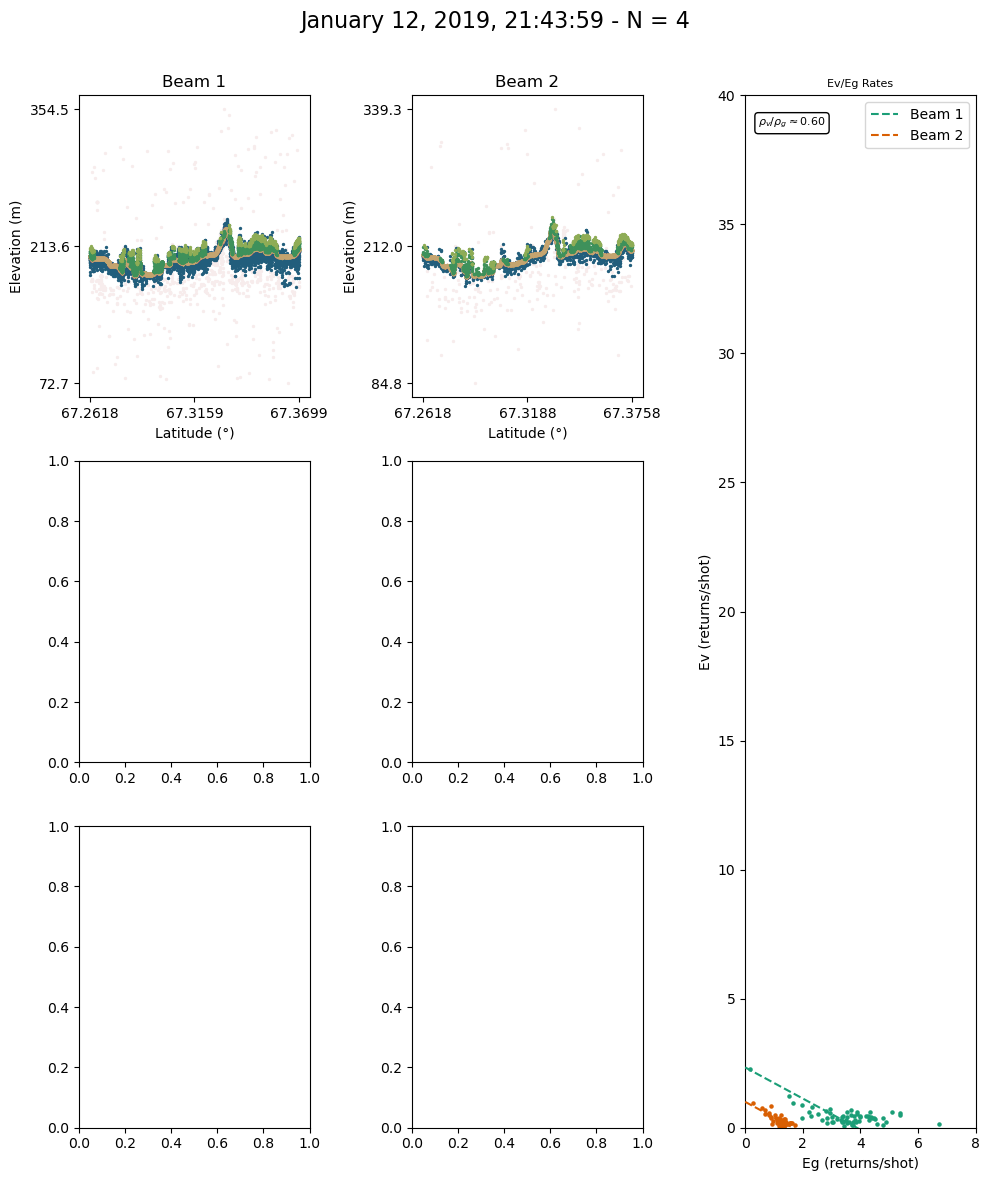

In [22]:
dirpath = '../data_store/data/sodankyla_full/'

all_ATL03, all_ATL08 = track_pairs(dirpath)
N = len(all_ATL03)

sodankyla_coords = (26.634154, 67.361833)

for i in [4]:
    data = pvpg_parallel(all_ATL03[i], all_ATL08[i], coords=sodankyla_coords, width=.1,height=.1,\
                         graph_detail=2, loss='arctan',file_index=i, keep_flagged=1, opsys='bad',f_scale=.1)

# Land Cover Filtered to Forests

Beam 3 in file 4 has been skipped because of no data.
Beam 4 in file 4 has been skipped because of no data.
Beam 5 in file 4 has been skipped because of no data.
Beam 6 in file 4 has been skipped because of no data.


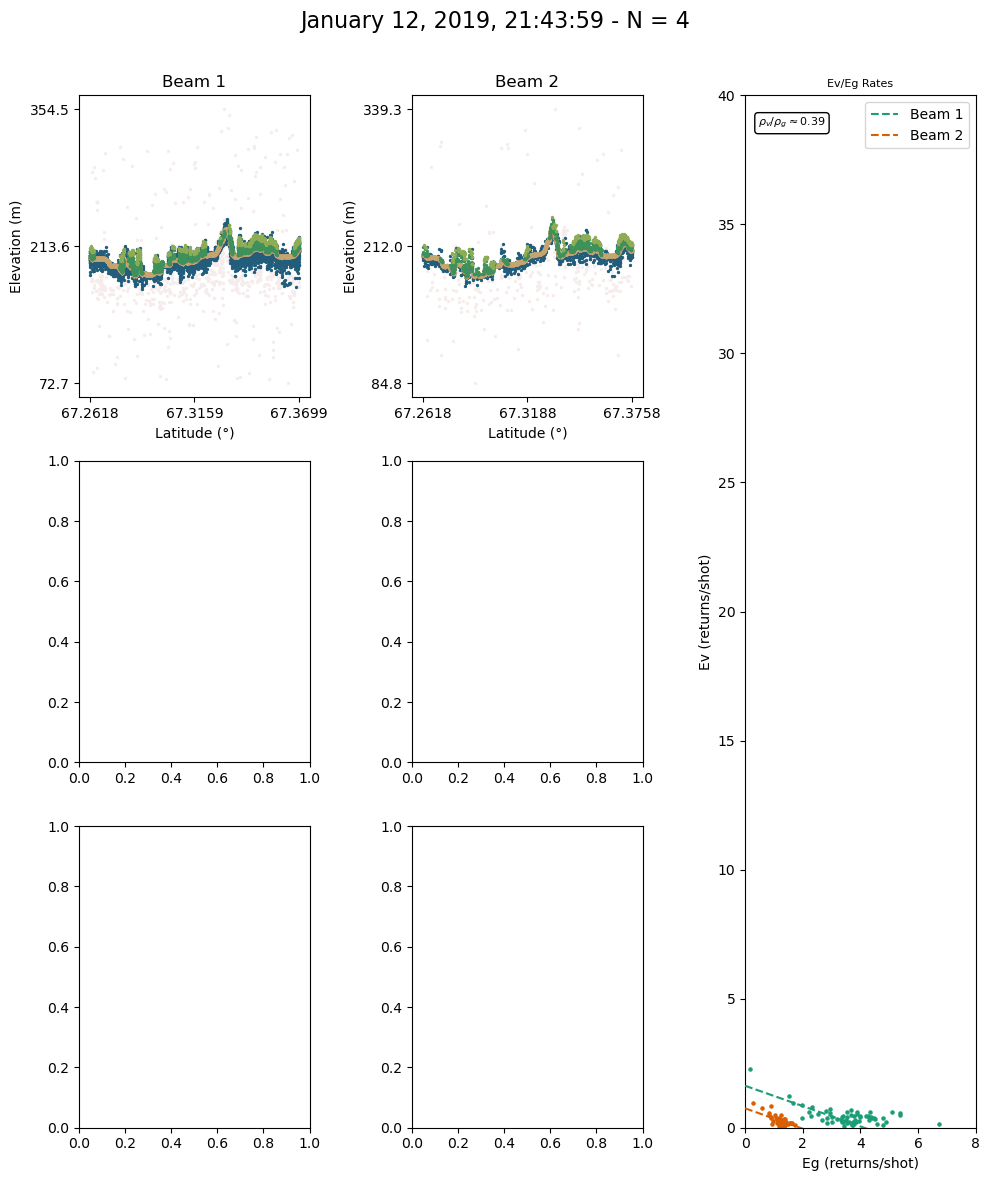

In [24]:
dirpath = '../data_store/data/sodankyla_full/'

all_ATL03, all_ATL08 = track_pairs(dirpath)
N = len(all_ATL03)

sodankyla_coords = (26.634154, 67.361833)

for i in [4]:
    data = pvpg_parallel(all_ATL03[i], all_ATL08[i], coords=sodankyla_coords, width=.1,height=.1,\
                         graph_detail=2, loss='arctan',file_index=i, keep_flagged=1, opsys='bad',f_scale=.1)

Beam 1 in file 0 has been skipped because of no data.
Beam 2 in file 0 has been skipped because of no data.
Beam 3 in file 0 has been skipped because of no data.
Beam 4 in file 0 has been skipped because of no data.
Beam 5 in file 0 has been skipped because of no data.
Beam 6 in file 0 has been skipped because of no data.
Empty DataFrame
Columns: [Eg, Ev]
Index: []
No beams have data in file 0, cannot regress.
Beam 1 in file 1 has been skipped because of no data.
Beam 2 in file 1 has been skipped because of no data.
Beam 3 in file 1 has been skipped because of no data.
Beam 4 in file 1 has been skipped because of no data.
Beam 5 in file 1 has been skipped because of no data.
Beam 6 in file 1 has been skipped because of no data.
Empty DataFrame
Columns: [Eg, Ev]
Index: []
No beams have data in file 1, cannot regress.
Beam 1 in file 2 has been skipped because of no data.
Beam 2 in file 2 has been skipped because of no data.
Beam 3 in file 2 has been skipped because of no data.
Beam 4 in 

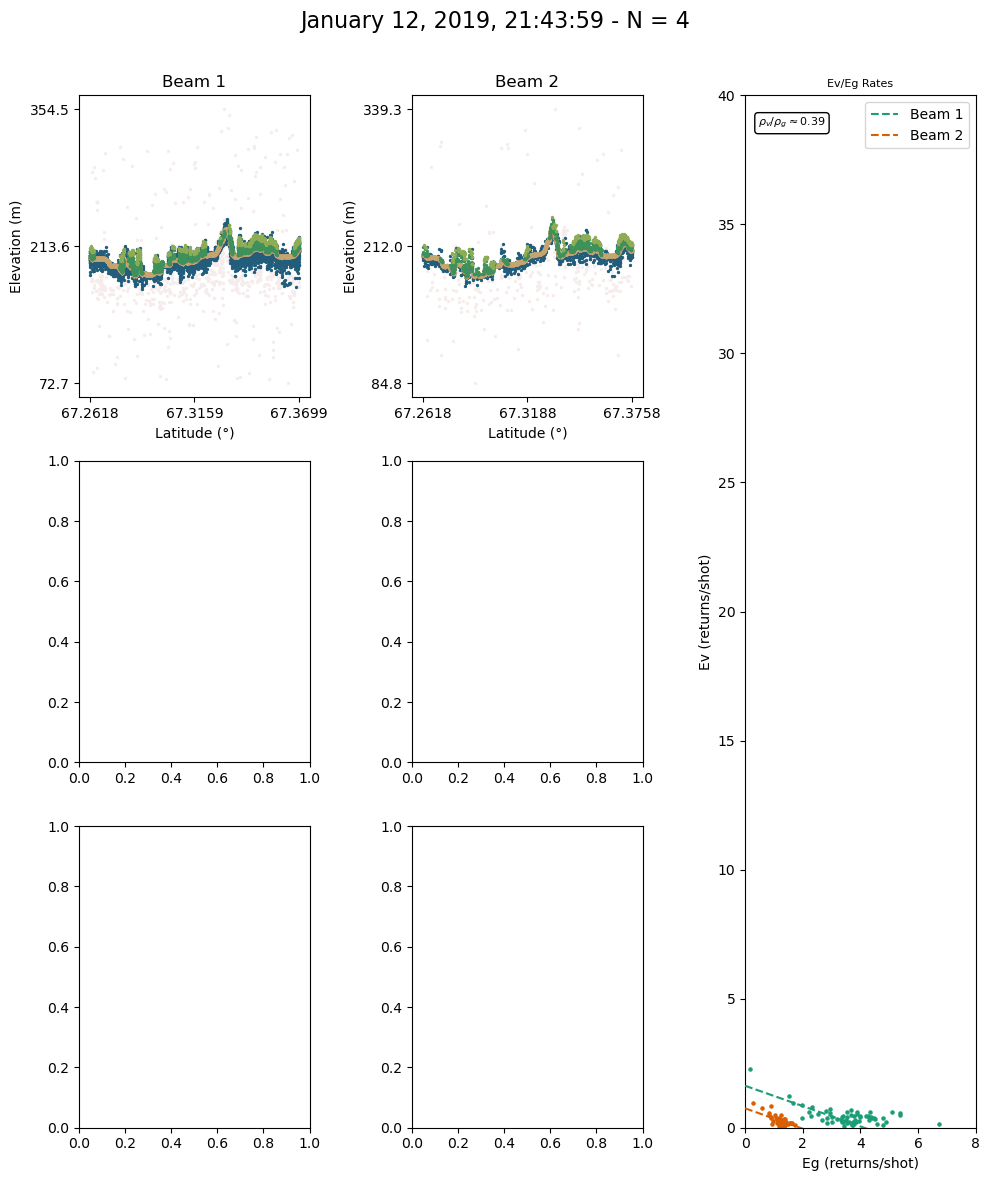

Beam 1 in file 5 has been skipped because of no data.
Beam 2 in file 5 has been skipped because of no data.
           Eg        Ev  Beam 3  Beam 4  Beam 5  Beam 6
0    0.040000  0.448000    True   False   False   False
1    0.114504  0.534351    True   False   False   False
2    0.070866  0.385827    True   False   False   False
3    0.084615  0.400000    True   False   False   False
4    0.067797  0.567797    True   False   False   False
..        ...       ...     ...     ...     ...     ...
348  0.960938  1.023438   False   False   False    True
349  1.346154  0.346154   False   False   False    True
350  0.893939  0.977273   False   False   False    True
351  0.920635  1.047619   False   False   False    True
352  1.589147  0.248062   False   False   False    True

[353 rows x 6 columns]


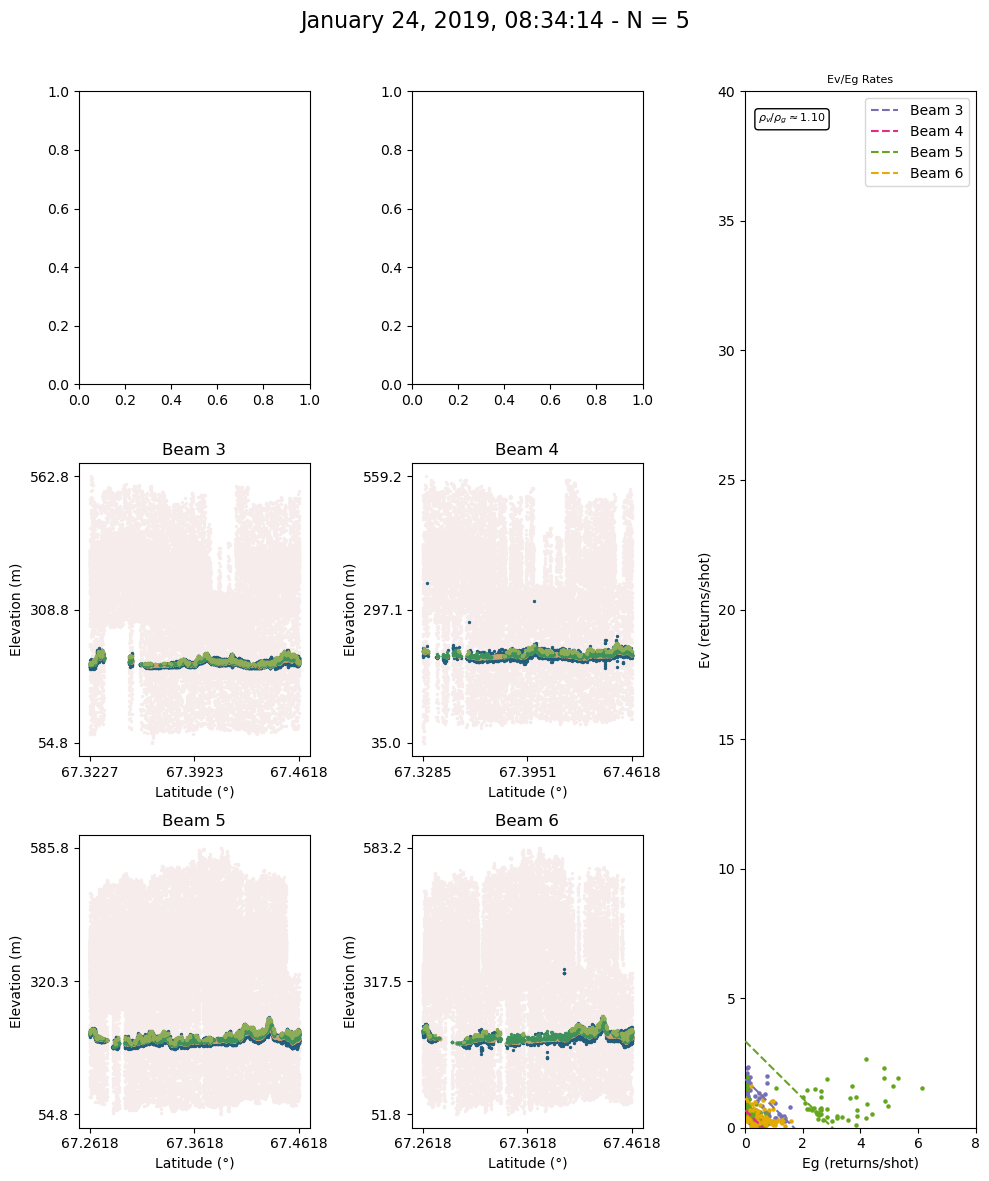

Beam 1 in file 6 has been skipped because of no data.
Beam 2 in file 6 has been skipped because of no data.
Beam 3 in file 6 has been skipped because of no data.
Beam 4 in file 6 has been skipped because of no data.
Beam 5 in file 6 has been skipped because of no data.
Beam 6 in file 6 has been skipped because of no data.
Empty DataFrame
Columns: [Eg, Ev]
Index: []
No beams have data in file 6, cannot regress.
Beam 2 in file 7 has been skipped because of no data.
Beam 3 in file 7 has been skipped because of no data.
Beam 4 in file 7 has been skipped because of no data.
Beam 5 in file 7 has been skipped because of no data.
Beam 6 in file 7 has been skipped because of no data.
          Eg        Ev  Beam 1
0   0.015038  0.293233    True
1   0.007299  0.394161    True
2   0.187970  0.135338    True
3   0.179688  0.242188    True
4   0.051095  0.277372    True
5   0.028986  0.318841    True
6   0.096296  0.325926    True
7   0.029630  0.407407    True
8   0.022556  0.345865    True
9   0.

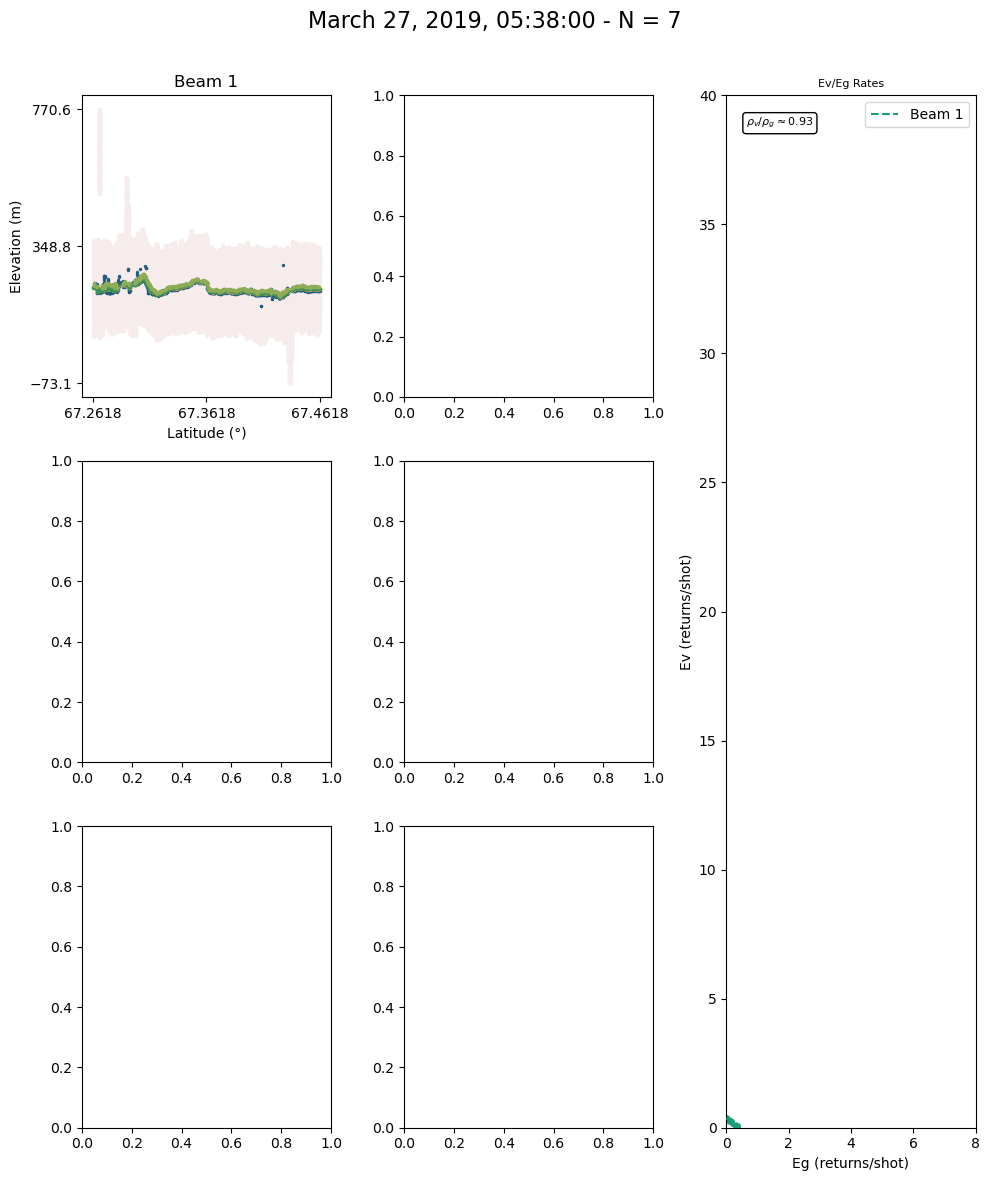

Beam 5 in file 8 has been skipped because of no data.
Beam 6 in file 8 has been skipped because of no data.
           Eg        Ev  Beam 1  Beam 2  Beam 3  Beam 4
0    1.923664  0.106870    True   False   False   False
1    1.593985  0.518797    True   False   False   False
2    1.132812  1.085938    True   False   False   False
3    1.888000  0.128000    True   False   False   False
4    1.504202  0.184874    True   False   False   False
..        ...       ...     ...     ...     ...     ...
220  1.053192  0.085106   False   False   False    True
221  1.045455  0.090909   False   False   False    True
222  1.073684  0.115789   False   False   False    True
223  0.427184  1.106796   False   False   False    True
224  1.218750  0.406250   False   False   False    True

[225 rows x 6 columns]


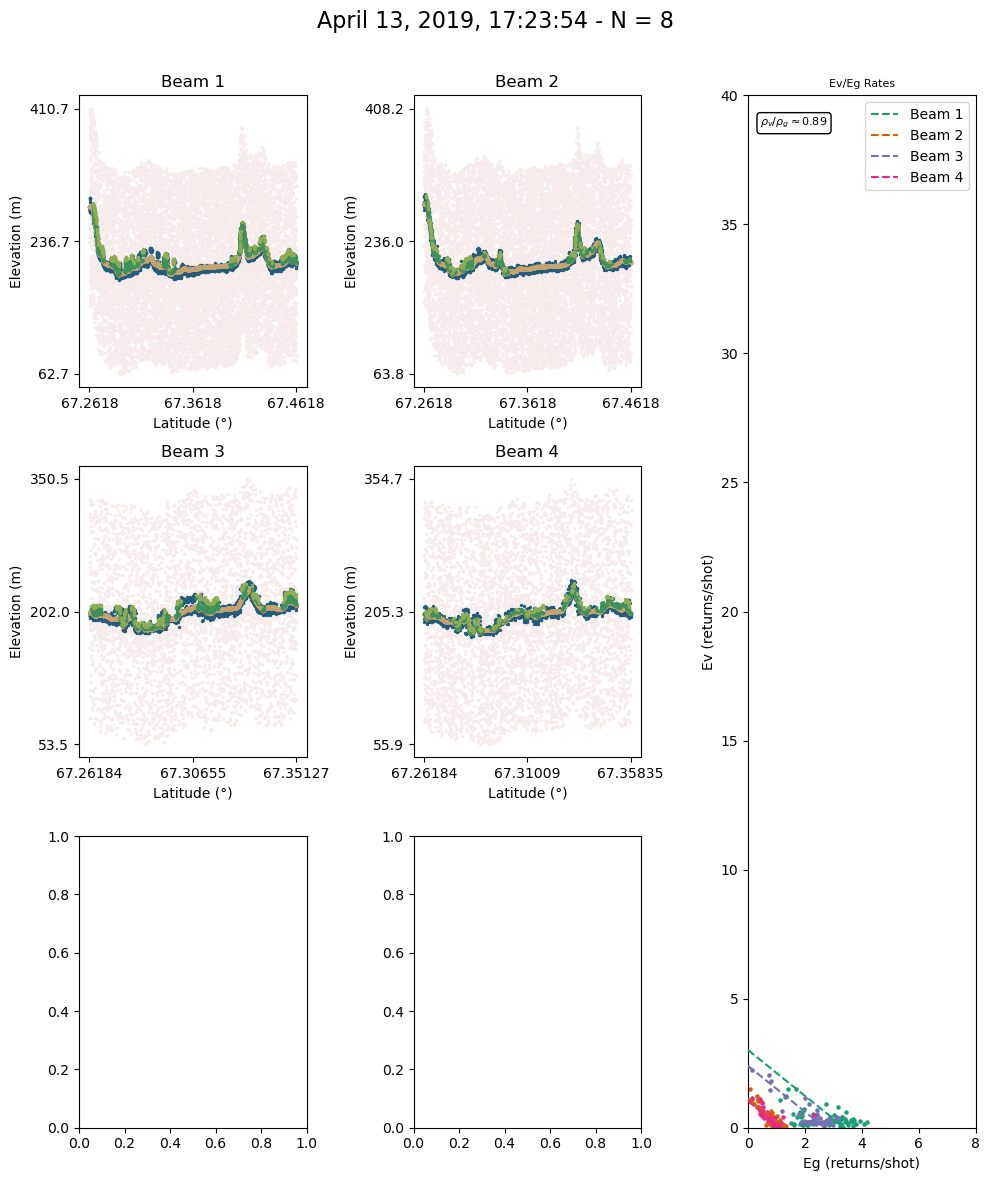

Beam 1 in file 9 has been skipped because of no data.
Beam 2 in file 9 has been skipped because of no data.
           Eg        Ev  Beam 3  Beam 4  Beam 5  Beam 6
0    2.700000  0.485714    True   False   False   False
1    1.652174  0.927536    True   False   False   False
2    2.258993  1.417266    True   False   False   False
3    3.107143  0.335714    True   False   False   False
4    1.785714  1.492857    True   False   False   False
..        ...       ...     ...     ...     ...     ...
161  0.818841  0.702899   False   False   False    True
162  1.277372  0.343066   False   False   False    True
163  0.652542  0.110169   False   False   False    True
164  0.733333  0.259259   False   False   False    True
165  0.516393  0.270492   False   False   False    True

[166 rows x 6 columns]


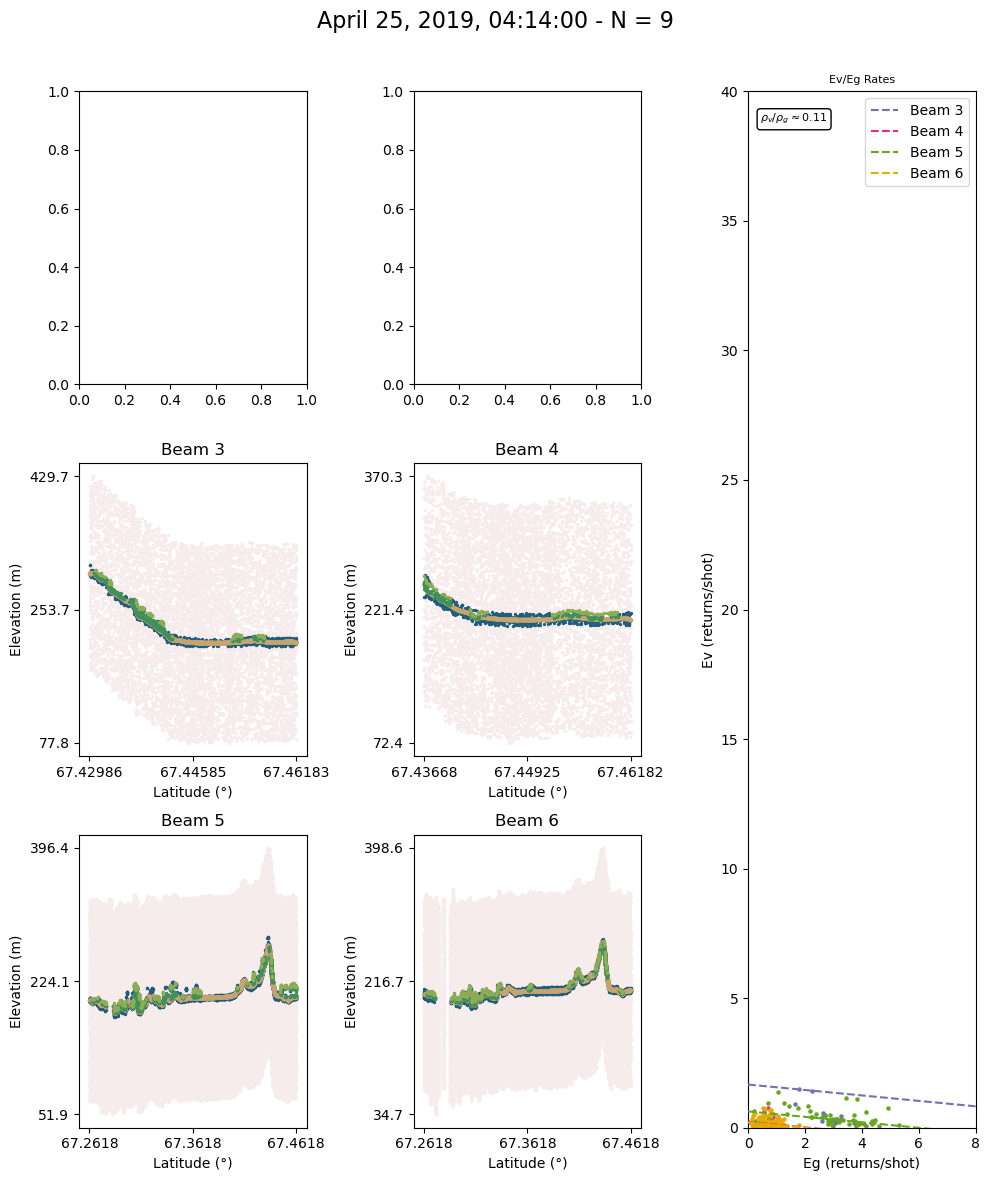

Beam 1 in file 10 has been skipped because of no data.
Beam 2 in file 10 has been skipped because of no data.
Beam 3 in file 10 has been skipped because of no data.
Beam 4 in file 10 has been skipped because of no data.
           Eg        Ev  Beam 5  Beam 6
0    0.954887  0.406015    True   False
1    0.789474  0.541353    True   False
2    0.884058  0.847826    True   False
3    1.135338  0.390977    True   False
4    1.185185  0.451852    True   False
..        ...       ...     ...     ...
105  0.318182  0.381818   False    True
106  0.222222  0.393162   False    True
107  0.230769  0.350427   False    True
108  0.225225  0.324324   False    True
109  0.212963  0.305556   False    True

[110 rows x 4 columns]


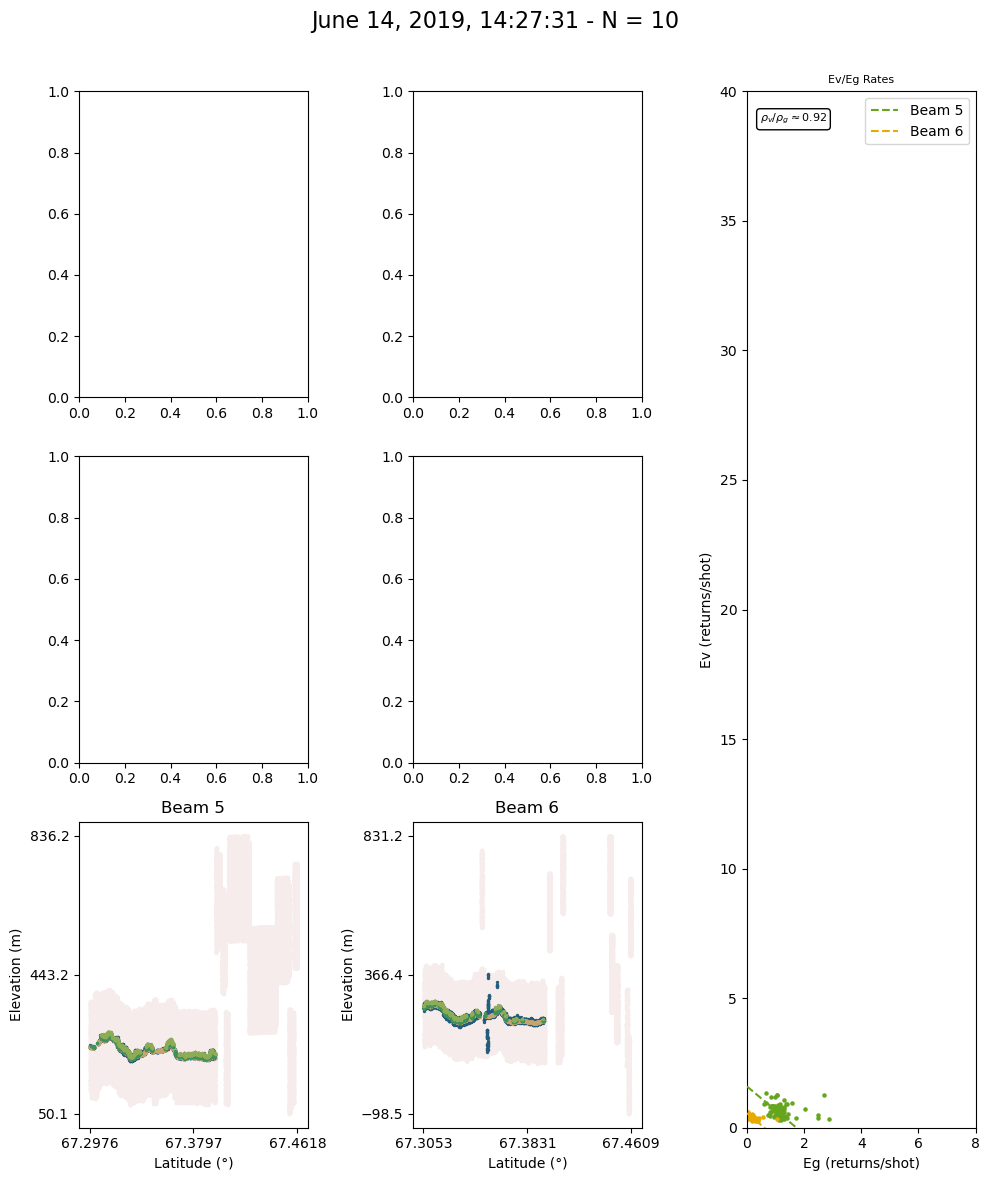

Beam 3 in file 11 has been skipped because of no data.
Beam 4 in file 11 has been skipped because of no data.
Beam 5 in file 11 has been skipped because of no data.
Beam 6 in file 11 has been skipped because of no data.
          Eg        Ev  Beam 1  Beam 2
0   0.851485  0.108911    True   False
1   1.516949  0.500000    True   False
2   1.724138  0.491379    True   False
3   0.480769  0.711538    True   False
4   0.459770  0.252874    True   False
5   0.552632  0.197368    True   False
6   0.402299  0.390805    True   False
7   0.296703  0.637363    True   False
8   0.738739  0.486486    True   False
9   1.008475  0.364407    True   False
10  1.125000  0.383929    True   False
11  0.600000  0.244444    True   False
12  0.478723  0.404255    True   False
13  0.350649  0.350649    True   False
14  0.451219  0.341463    True   False
15  0.945946  0.315315    True   False
16  0.819048  0.590476    True   False
17  0.479592  0.581633    True   False
18  1.083333  0.175000    True   False


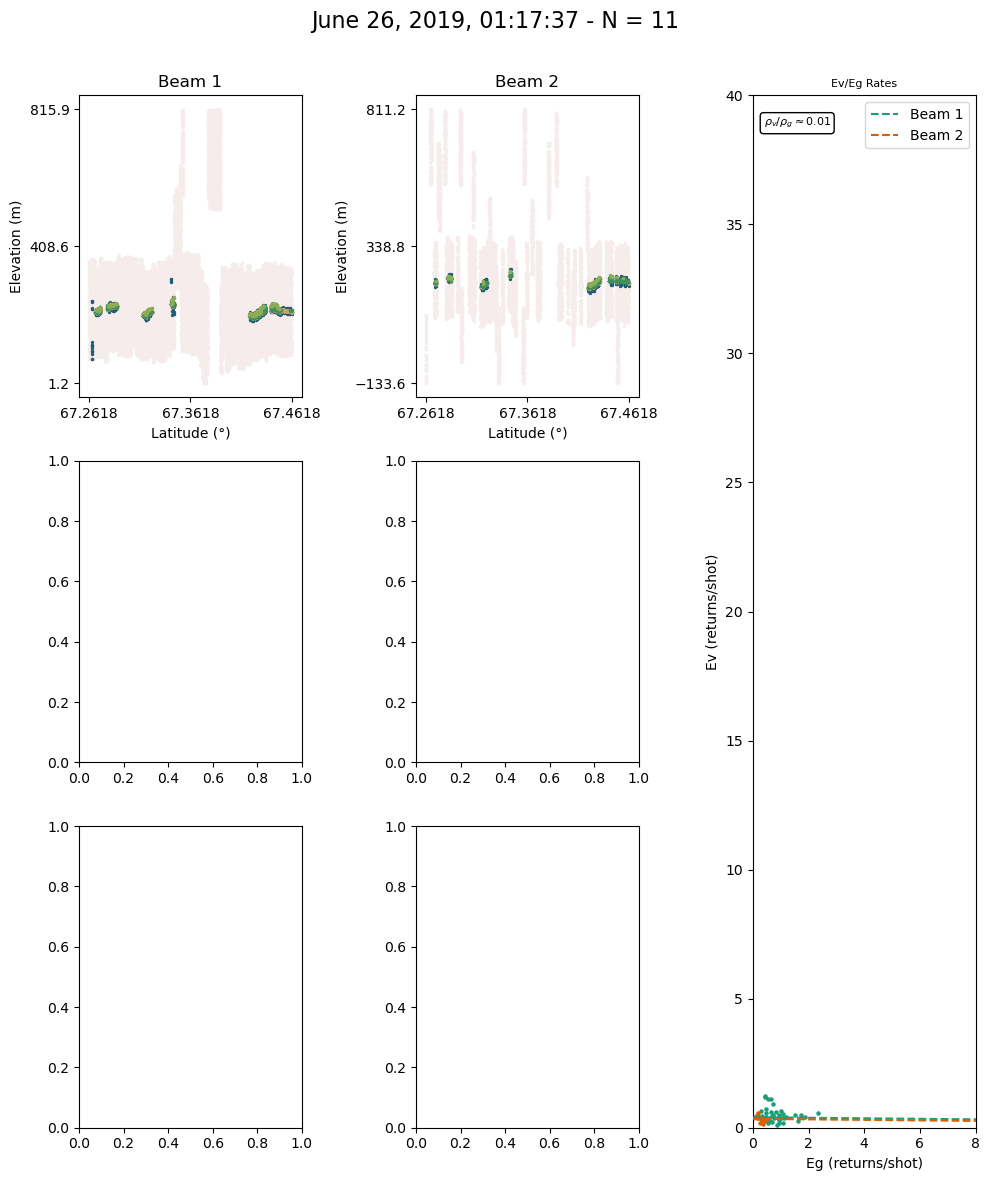

Beam 1 in file 12 has been skipped because of no data.
Beam 2 in file 12 has been skipped because of no data.
Beam 3 in file 12 has been skipped because of no data.
Beam 4 in file 12 has been skipped because of no data.
Beam 5 in file 12 has been skipped because of no data.
Beam 6 in file 12 has been skipped because of no data.
Empty DataFrame
Columns: [Eg, Ev]
Index: []
No beams have data in file 12, cannot regress.
Beam 1 in file 13 has been skipped because of no data.
Beam 2 in file 13 has been skipped because of no data.
Beam 3 in file 13 has been skipped because of no data.
Beam 4 in file 13 has been skipped because of no data.
Beam 5 in file 13 has been skipped because of no data.
Beam 6 in file 13 has been skipped because of no data.
Empty DataFrame
Columns: [Eg, Ev]
Index: []
No beams have data in file 13, cannot regress.
Beam 1 in file 14 has been skipped because of no data.
Beam 2 in file 14 has been skipped because of no data.
Beam 3 in file 14 has been skipped because of no

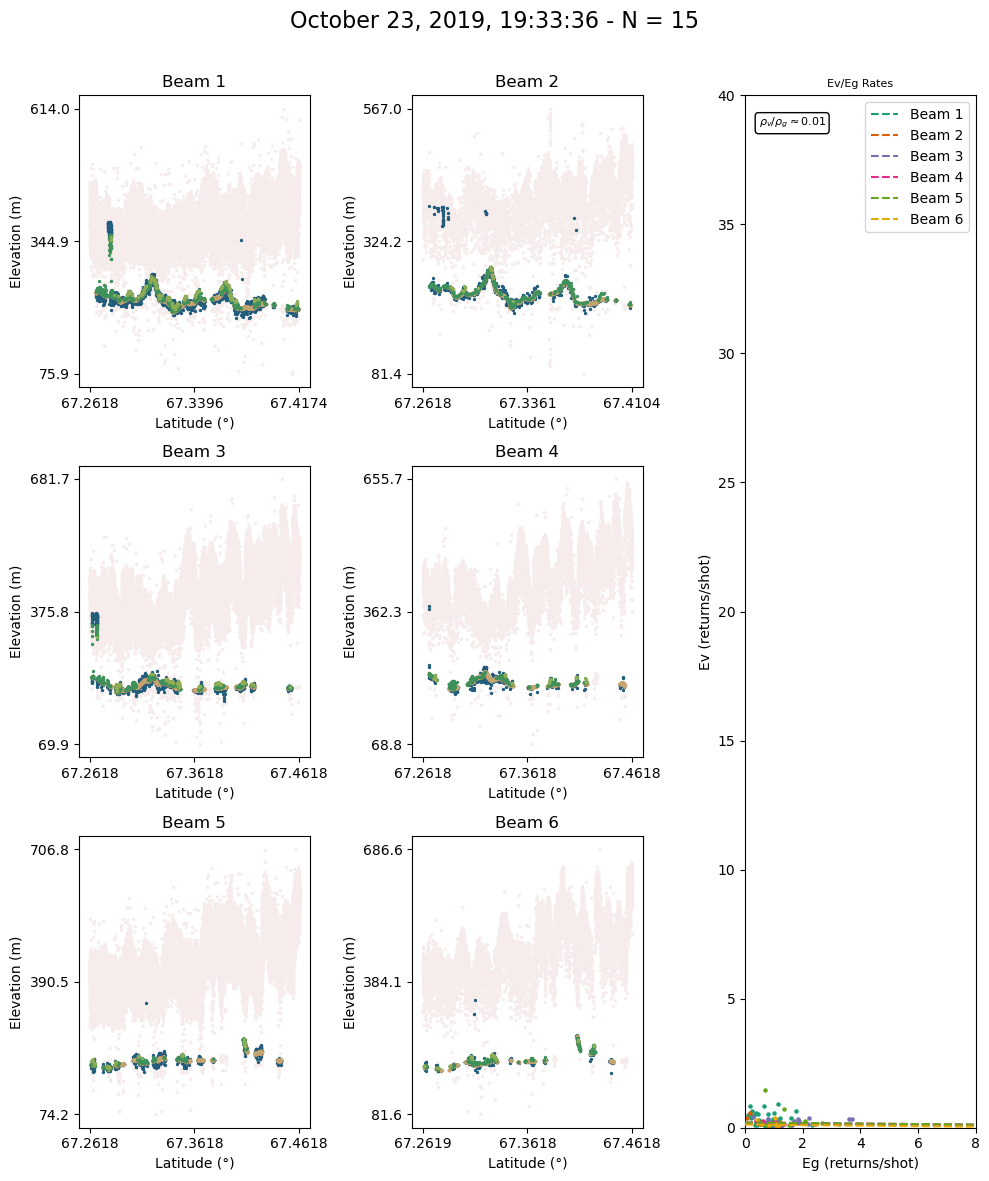

           Eg        Ev  Beam 1  Beam 2  Beam 3  Beam 4  Beam 5  Beam 6
0    2.678571  1.442857    True   False   False   False   False   False
1    3.241135  1.184397    True   False   False   False   False   False
2    5.276596  0.120567    True   False   False   False   False   False
3    4.778572  0.385714    True   False   False   False   False   False
4    5.382979  0.070922    True   False   False   False   False   False
..        ...       ...     ...     ...     ...     ...     ...     ...
551  1.303571  0.357143   False   False   False   False   False    True
552  1.262712  0.364407   False   False   False   False   False    True
553  1.288288  0.126126   False   False   False   False   False    True
554  1.318966  0.155172   False   False   False   False   False    True
555  1.279279  0.171171   False   False   False   False   False    True

[556 rows x 8 columns]


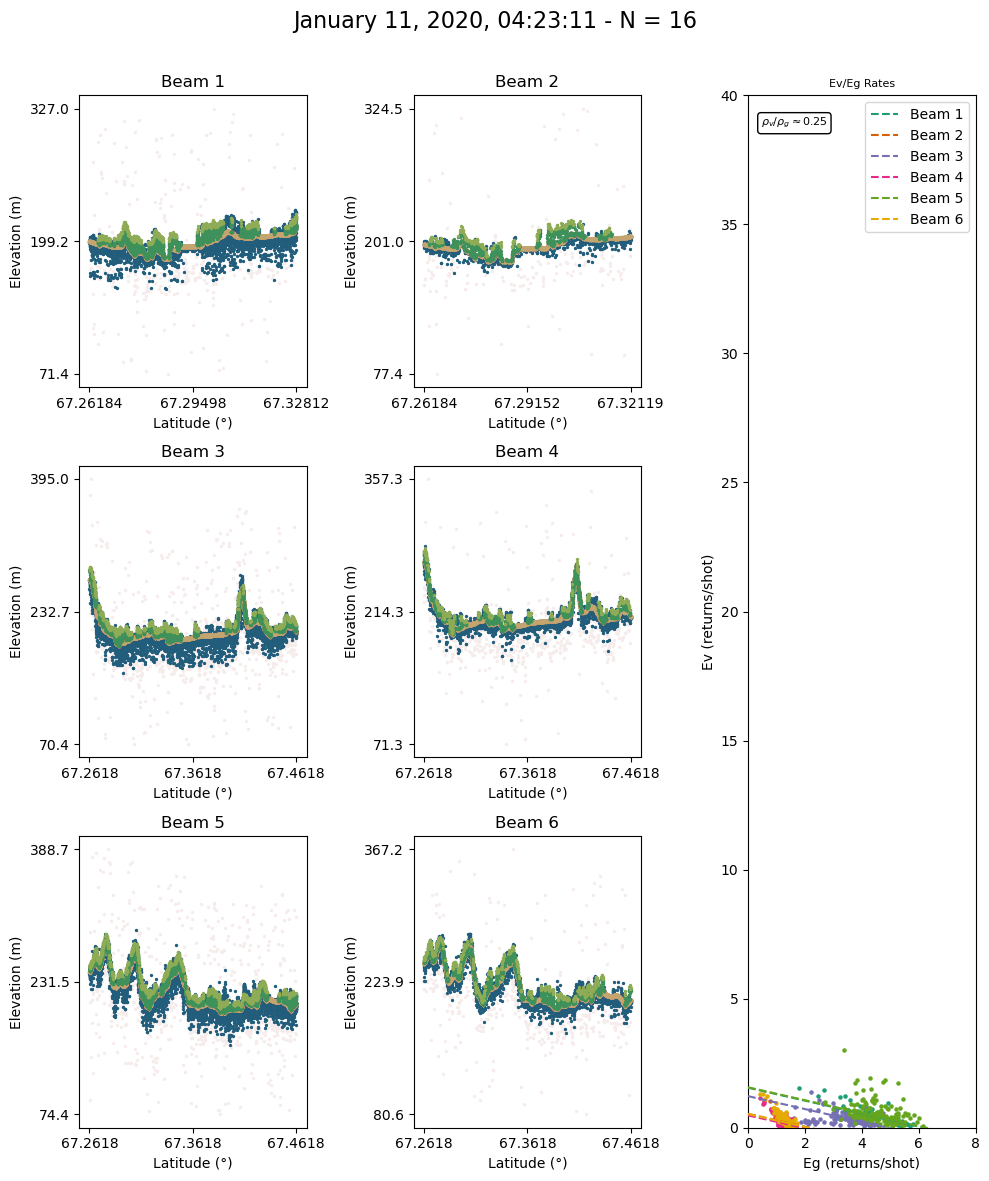

Beam 3 in file 17 has been skipped because of no data.
Beam 4 in file 17 has been skipped because of no data.
Beam 5 in file 17 has been skipped because of no data.
Beam 6 in file 17 has been skipped because of no data.
           Eg        Ev  Beam 1  Beam 2
0    5.531915  0.354610    True   False
1    6.260563  0.443662    True   False
2    6.248227  0.248227    True   False
3    6.021583  0.402878    True   False
4    5.809859  0.584507    True   False
..        ...       ...     ...     ...
107  1.565574  0.229508   False    True
108  1.709677  0.088710   False    True
109  1.650794  0.166667   False    True
110  1.658537  0.121951   False    True
111  1.593750  0.320312   False    True

[112 rows x 4 columns]


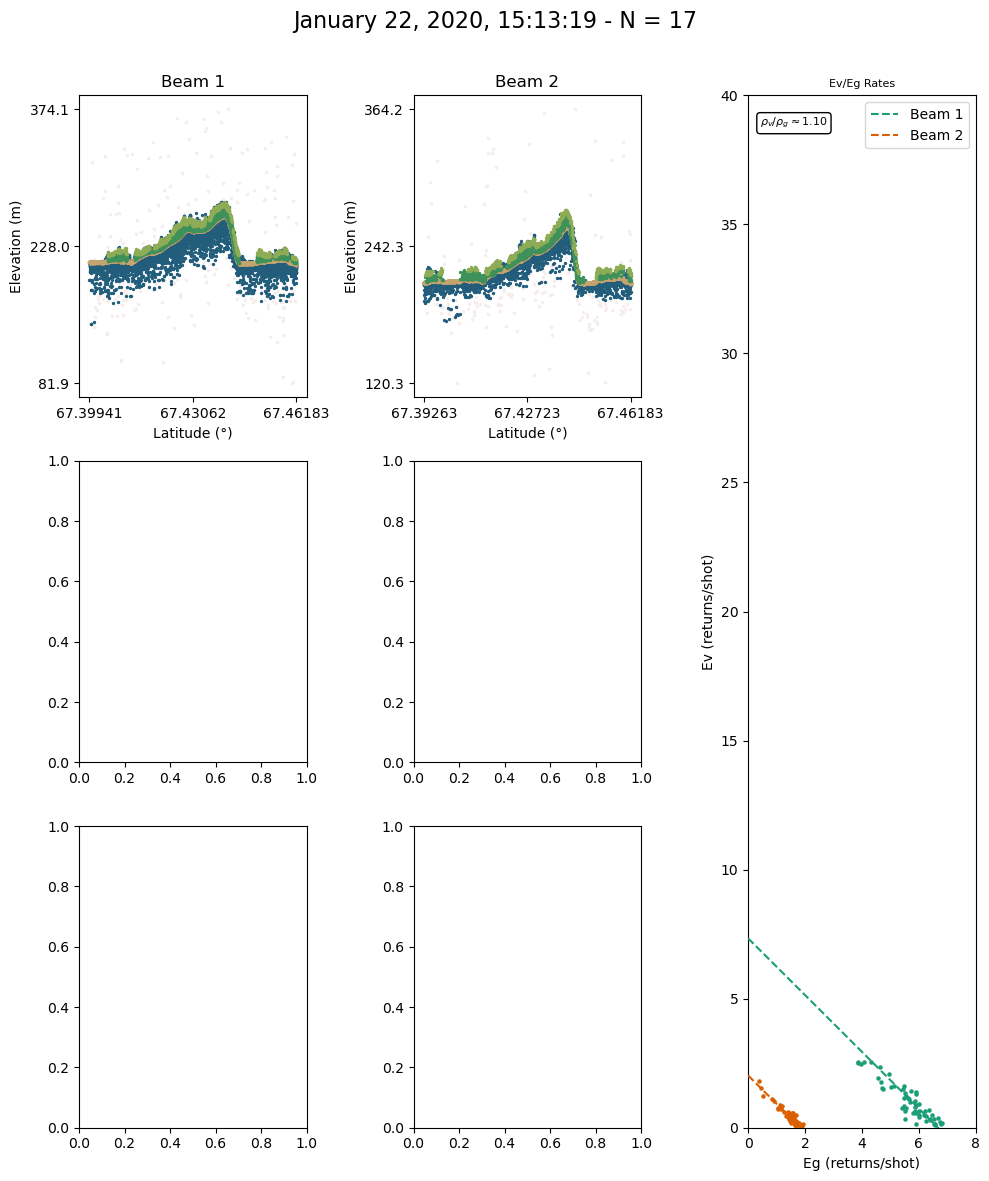

Beam 1 in file 18 has been skipped because of no data.
Beam 2 in file 18 has been skipped because of no data.
Beam 5 in file 18 has been skipped because of no data.
         Eg        Ev  Beam 3  Beam 4  Beam 6
0  3.858156  0.439716    True   False   False
1  2.673759  1.588652    True   False   False
2  3.503546  1.276596    True   False   False
3  0.460432  1.000000   False    True   False
4  0.460993  1.439716   False    True   False
5  0.421429  1.250000   False    True   False
6  0.609929  1.127660   False    True   False
7  0.425532  1.141844   False   False    True


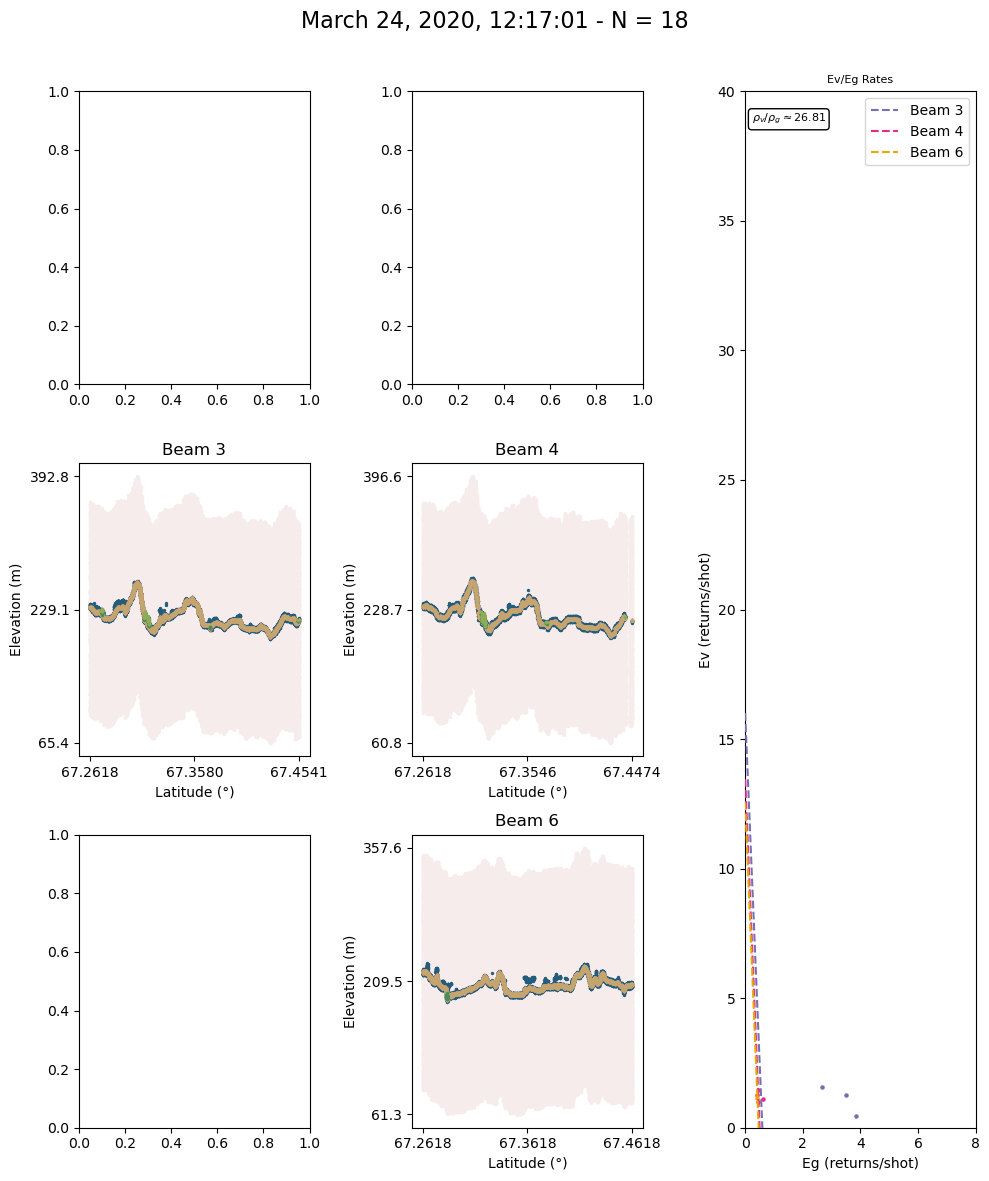

Beam 1 in file 19 has been skipped because of no data.
Beam 2 in file 19 has been skipped because of no data.
           Eg        Ev  Beam 3  Beam 4  Beam 5  Beam 6
0    3.784173  0.244604    True   False   False   False
1    4.050360  0.215827    True   False   False   False
2    3.822695  0.127660    True   False   False   False
3    3.567376  0.212766    True   False   False   False
4    3.414286  0.271429    True   False   False   False
..        ...       ...     ...     ...     ...     ...
206  1.221311  0.475410   False   False   False    True
207  1.074380  0.809917   False   False   False    True
208  1.257143  0.361905   False   False   False    True
209  1.504587  0.192661   False   False   False    True
210  1.433962  0.264151   False   False   False    True

[211 rows x 6 columns]


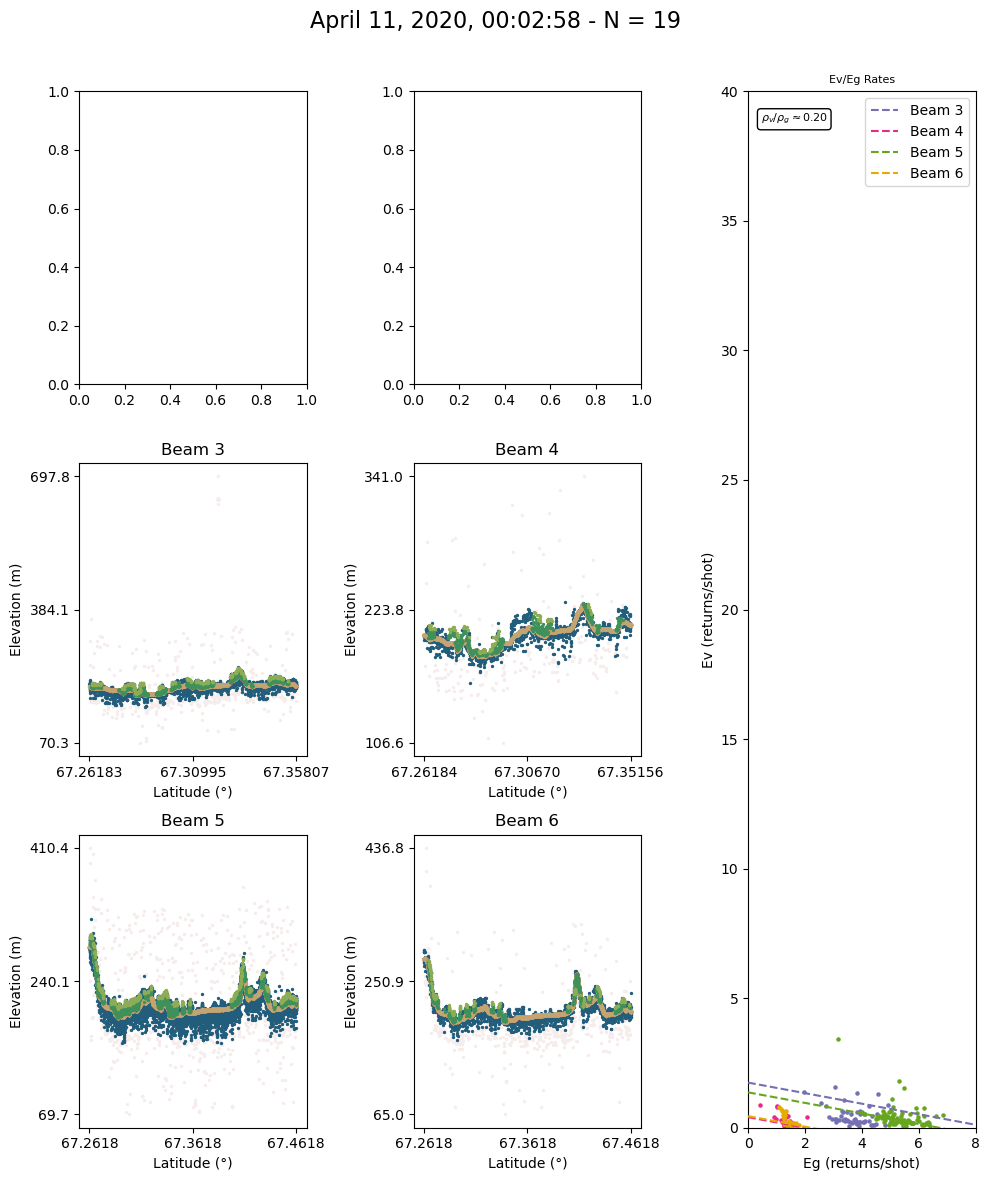

Beam 1 in file 20 has been skipped because of no data.
Beam 2 in file 20 has been skipped because of no data.
Beam 3 in file 20 has been skipped because of no data.
Beam 4 in file 20 has been skipped because of no data.
Beam 5 in file 20 has been skipped because of no data.
Beam 6 in file 20 has been skipped because of no data.
Empty DataFrame
Columns: [Eg, Ev]
Index: []
No beams have data in file 20, cannot regress.
Beam 1 in file 21 has been skipped because of no data.
Beam 2 in file 21 has been skipped because of no data.
Beam 3 in file 21 has been skipped because of no data.
Beam 4 in file 21 has been skipped because of no data.
           Eg        Ev  Beam 5  Beam 6
0    0.928000  1.240000    True   False
1    0.898305  0.906780    True   False
2    1.325203  1.235772    True   False
3    1.295082  0.377049    True   False
4    3.078947  0.701754    True   False
..        ...       ...     ...     ...
275  0.372549  0.411765   False    True
276  0.542373  0.491525   False    True

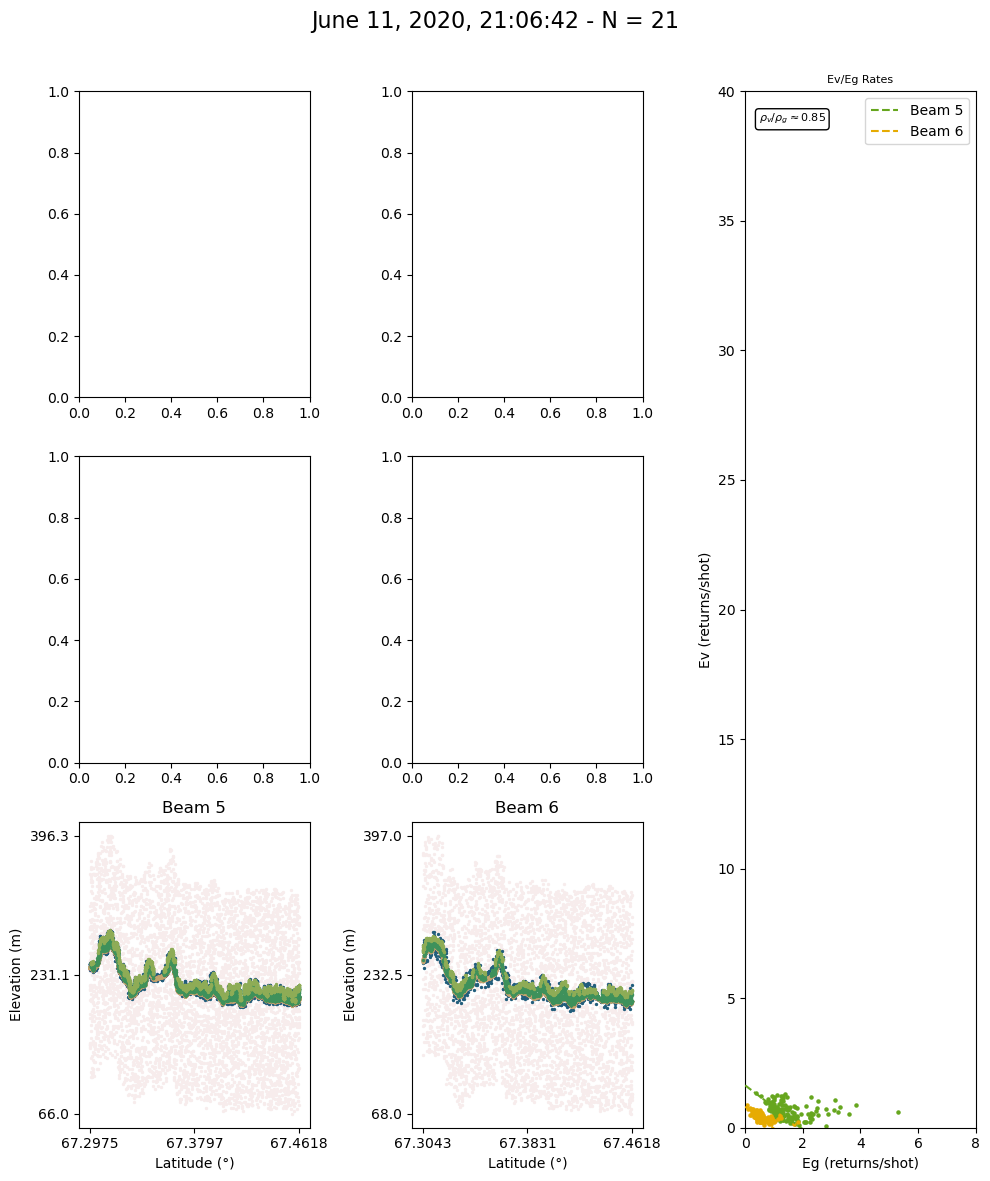

Beam 3 in file 22 has been skipped because of no data.
Beam 4 in file 22 has been skipped because of no data.
Beam 5 in file 22 has been skipped because of no data.
Beam 6 in file 22 has been skipped because of no data.
         Eg        Ev  Beam 1  Beam 2
0  0.613636  0.795455    True   False
1  0.606061  0.787879    True   False
2  0.846715  0.591241    True   False
3  0.819549  0.503759    True   False
4  0.891473  0.519380    True   False
5  0.782946  0.728682    True   False
6  0.041667  0.408333   False    True
7  0.000000  0.366071   False    True
8  0.023256  0.434109   False    True
9  0.008547  0.401709   False    True


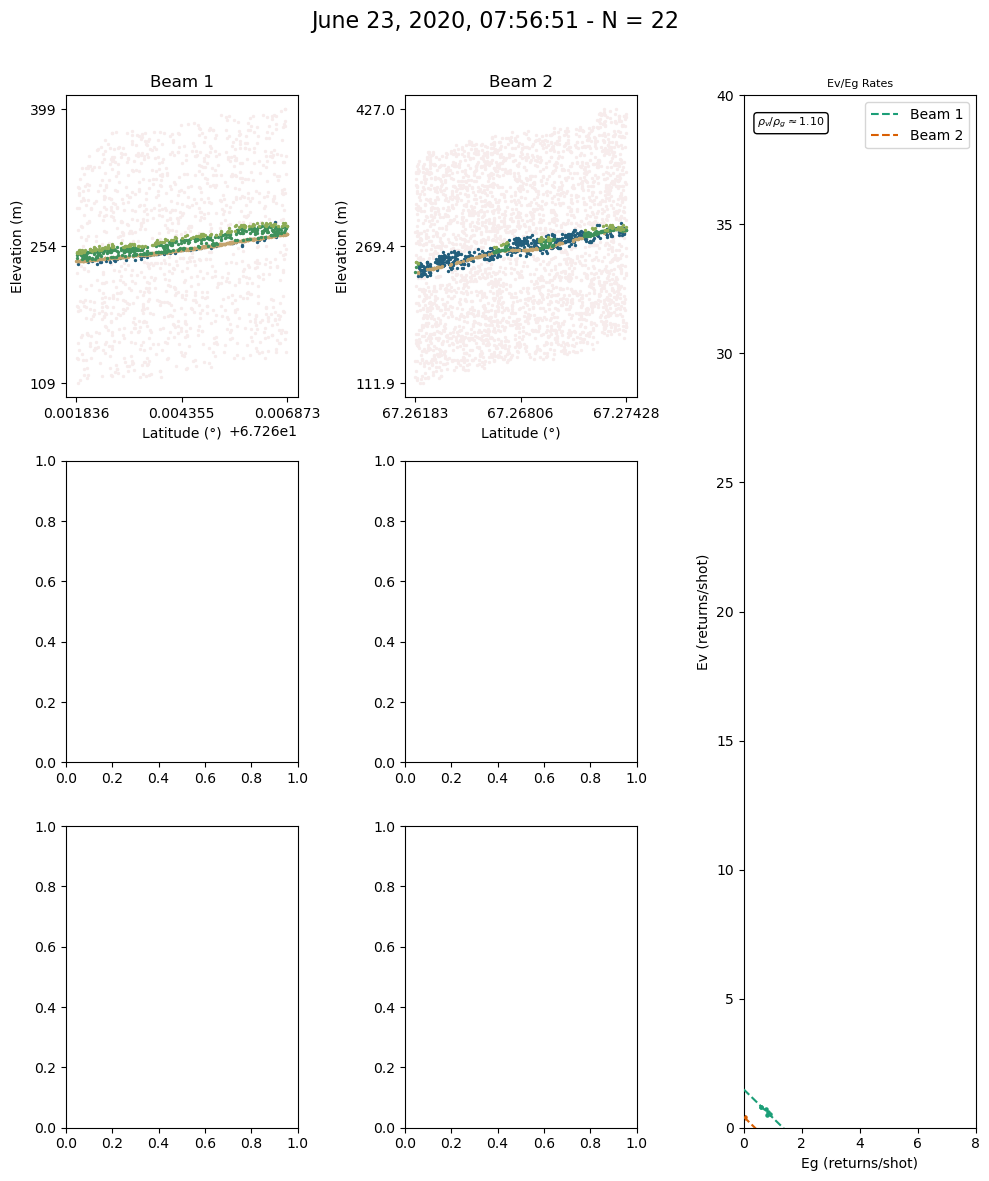

Beam 3 in file 23 has been skipped because of no data.
Beam 4 in file 23 has been skipped because of no data.
Beam 5 in file 23 has been skipped because of no data.
Beam 6 in file 23 has been skipped because of no data.
         Eg        Ev  Beam 1  Beam 2
0  0.264706  0.470588    True   False
1  0.646341  0.317073    True   False
2  0.362069  0.206897   False    True
3  1.460000  0.070000   False    True
4  0.509434  0.113208   False    True


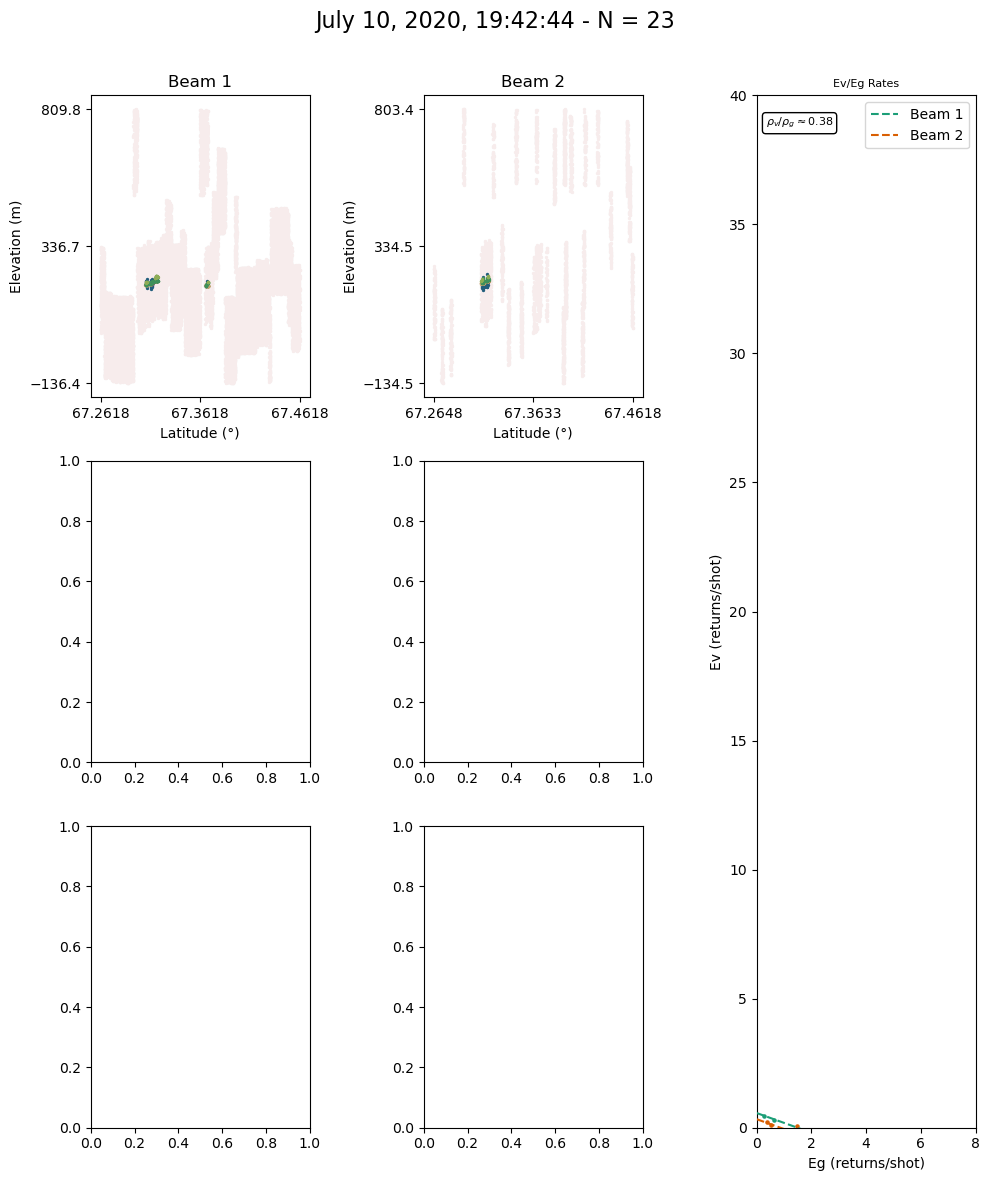

Beam 1 in file 24 has been skipped because of no data.
Beam 2 in file 24 has been skipped because of no data.
Beam 3 in file 24 has been skipped because of no data.
Beam 4 in file 24 has been skipped because of no data.
Beam 5 in file 24 has been skipped because of no data.
Beam 6 in file 24 has been skipped because of no data.
Empty DataFrame
Columns: [Eg, Ev]
Index: []
No beams have data in file 24, cannot regress.
Beam 1 in file 25 has been skipped because of no data.
Beam 2 in file 25 has been skipped because of no data.
Beam 3 in file 25 has been skipped because of no data.
Beam 4 in file 25 has been skipped because of no data.
           Eg        Ev  Beam 5  Beam 6
0    0.861111  1.046296    True   False
1    1.386792  0.396226    True   False
2    0.780702  0.956140    True   False
3    2.925000  0.983333    True   False
4    1.185841  0.424779    True   False
..        ...       ...     ...     ...
274  0.456522  0.413043   False    True
275  0.553191  0.276596   False    True

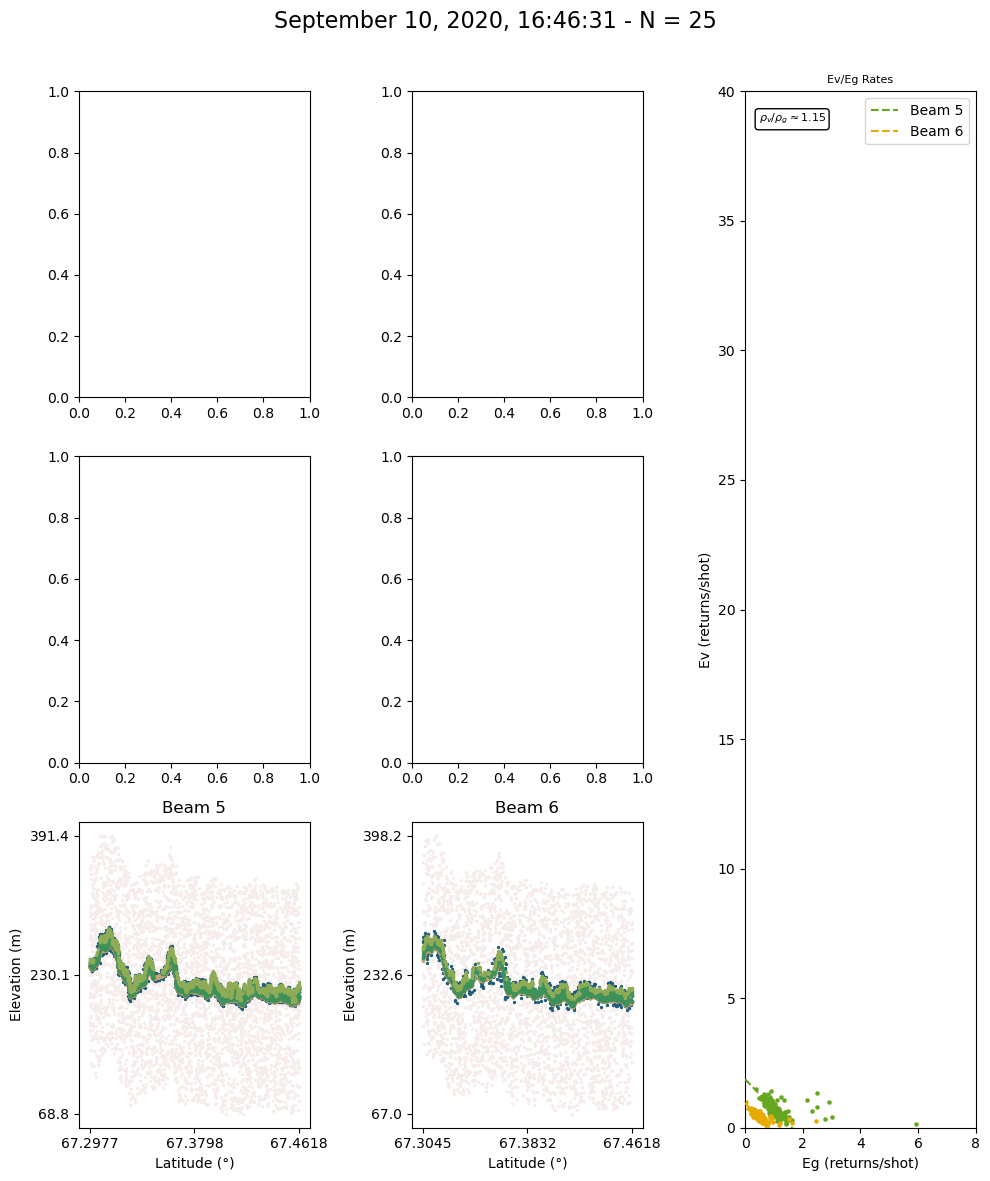

Beam 1 in file 26 has been skipped because of no data.
Beam 2 in file 26 has been skipped because of no data.
Beam 3 in file 26 has been skipped because of no data.
Beam 4 in file 26 has been skipped because of no data.
Beam 5 in file 26 has been skipped because of no data.
Beam 6 in file 26 has been skipped because of no data.
Empty DataFrame
Columns: [Eg, Ev]
Index: []
No beams have data in file 26, cannot regress.
Beam 2 in file 27 has been skipped because of no data.
Beam 3 in file 27 has been skipped because of no data.
Beam 4 in file 27 has been skipped because of no data.
Beam 5 in file 27 has been skipped because of no data.
Beam 6 in file 27 has been skipped because of no data.
         Eg        Ev  Beam 1
0  0.865385  0.211538    True
1  0.878378  0.324324    True
2  0.920635  0.571429    True
3  0.590909  0.575758    True


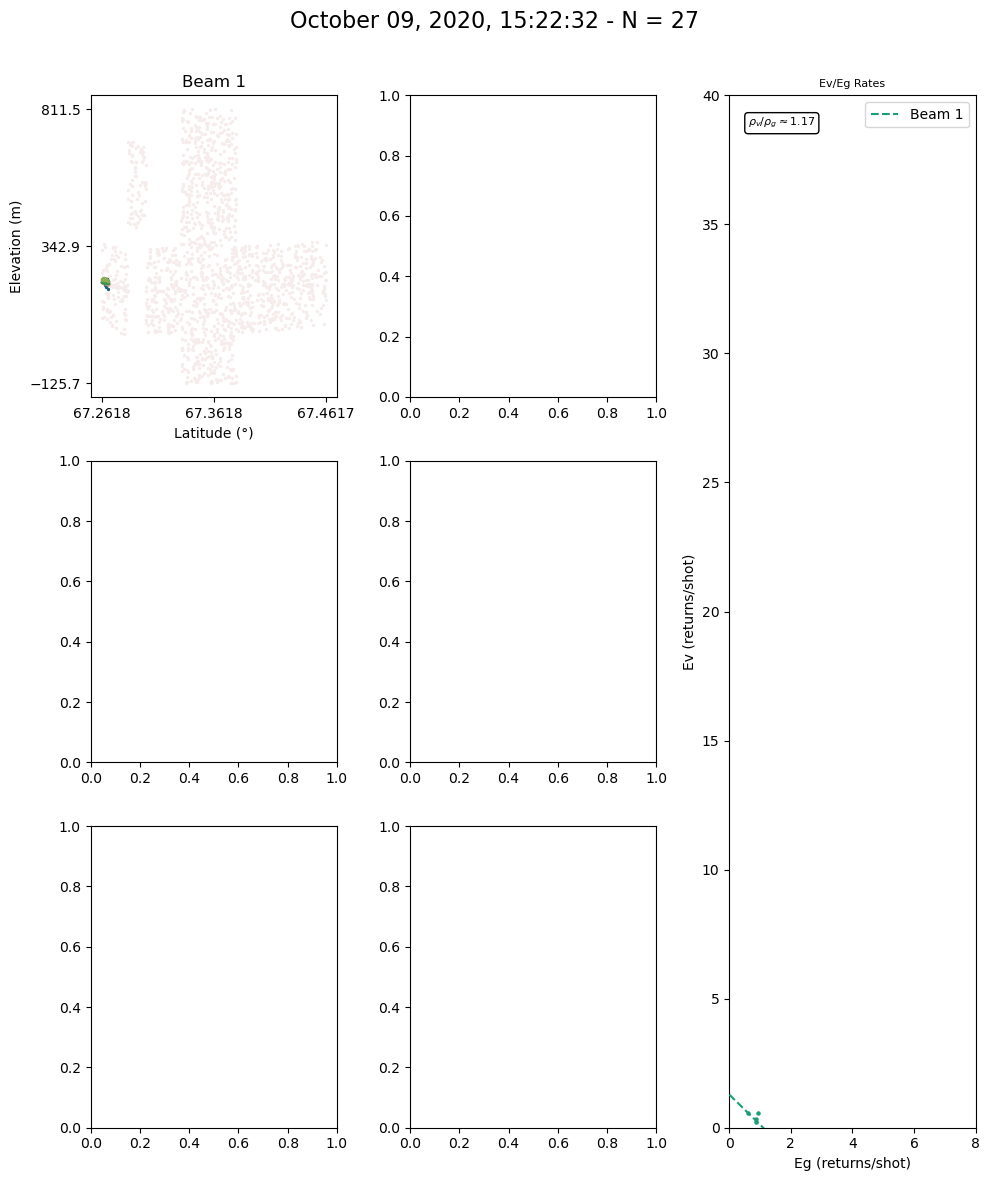

Beam 1 in file 28 has been skipped because of no data.
Beam 2 in file 28 has been skipped because of no data.
           Eg        Ev  Beam 3  Beam 4  Beam 5  Beam 6
0    0.177570  0.383178    True   False   False   False
1    0.553719  0.330579    True   False   False   False
2    1.040650  0.276423    True   False   False   False
3    1.015873  0.412698    True   False   False   False
4    0.243478  0.252174    True   False   False   False
..        ...       ...     ...     ...     ...     ...
160  0.290323  0.370968   False   False   False    True
161  0.514706  0.235294   False   False   False    True
162  0.544118  0.264706   False   False   False    True
163  0.840580  0.101449   False   False   False    True
164  0.419355  0.209677   False   False   False    True

[165 rows x 6 columns]


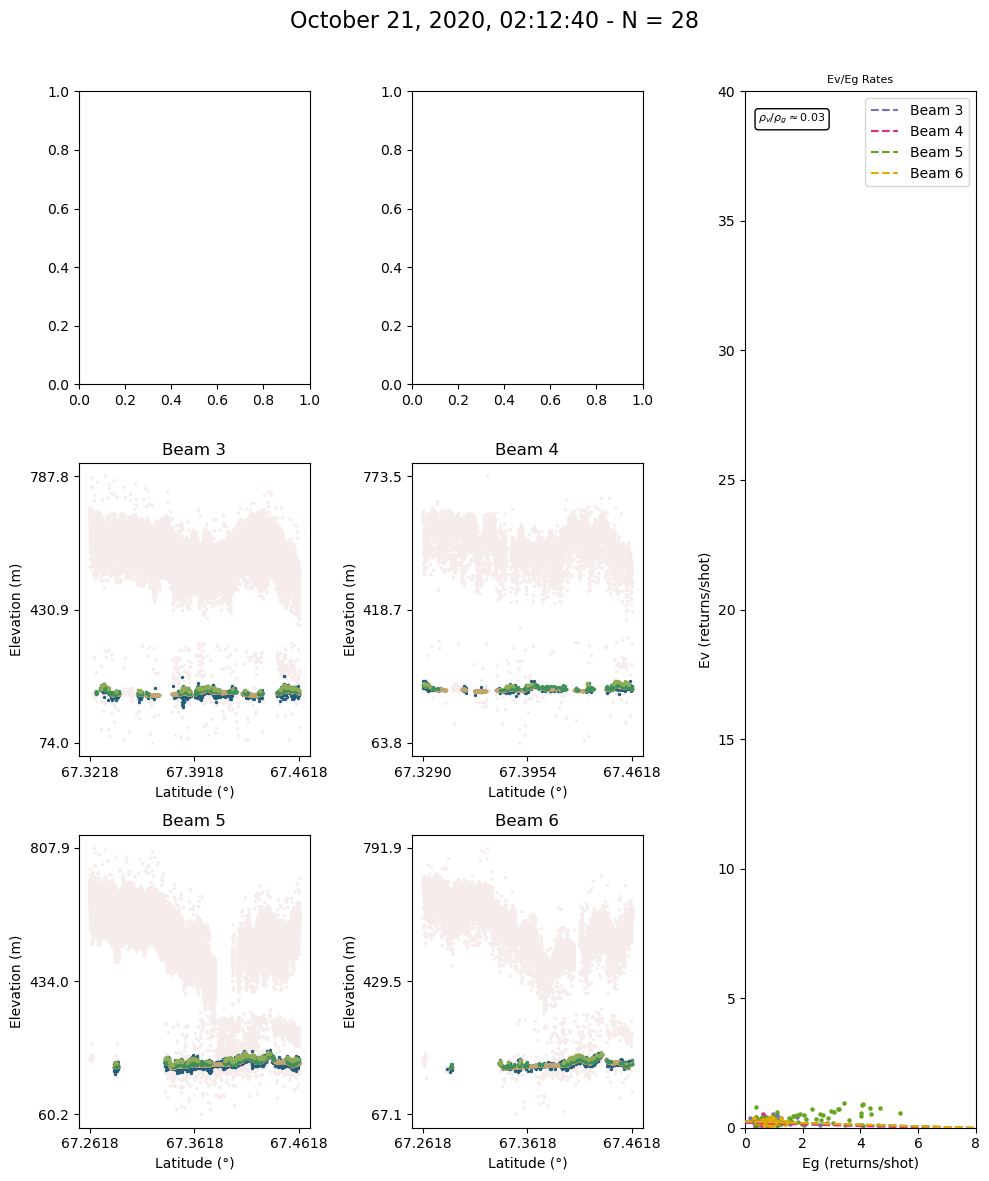

Beam 1 in file 29 has been skipped because of no data.
Beam 2 in file 29 has been skipped because of no data.
Beam 3 in file 29 has been skipped because of no data.
Beam 4 in file 29 has been skipped because of no data.
Beam 5 in file 29 has been skipped because of no data.
Beam 6 in file 29 has been skipped because of no data.
Empty DataFrame
Columns: [Eg, Ev]
Index: []
No beams have data in file 29, cannot regress.
Beam 1 in file 30 has been skipped because of no data.
Beam 2 in file 30 has been skipped because of no data.
Beam 3 in file 30 has been skipped because of no data.
Beam 4 in file 30 has been skipped because of no data.
Beam 5 in file 30 has been skipped because of no data.
Beam 6 in file 30 has been skipped because of no data.
Empty DataFrame
Columns: [Eg, Ev]
Index: []
No beams have data in file 30, cannot regress.
Beam 1 in file 31 has been skipped because of no data.
Beam 2 in file 31 has been skipped because of no data.
Beam 3 in file 31 has been skipped because of no

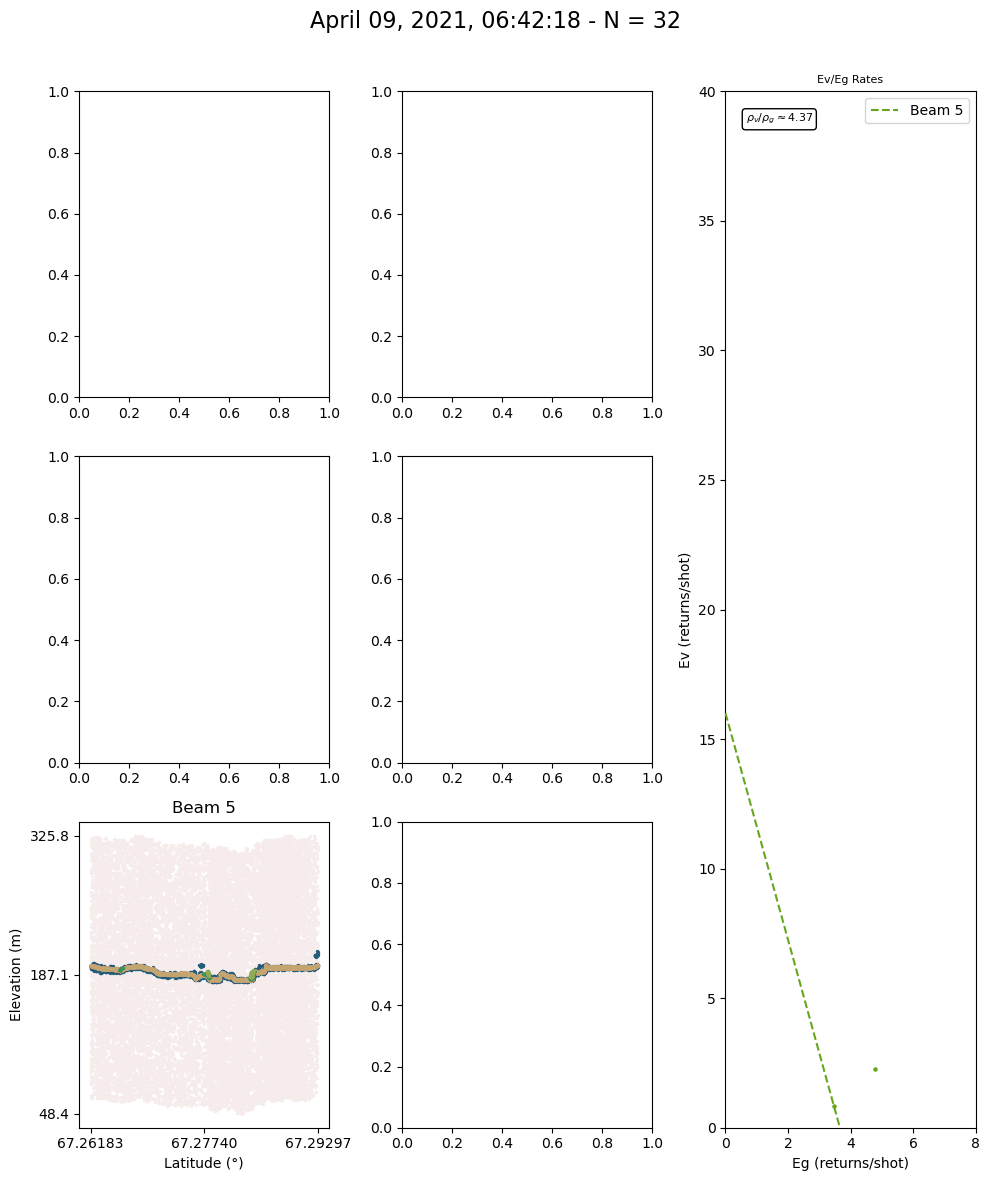

           Eg        Ev  Beam 1  Beam 2  Beam 3  Beam 4  Beam 5  Beam 6
0    1.430657  0.948905    True   False   False   False   False   False
1    1.659259  0.592593    True   False   False   False   False   False
2    2.036496  0.416058    True   False   False   False   False   False
3    2.425532  0.425532    True   False   False   False   False   False
4    2.584507  0.485915    True   False   False   False   False   False
..        ...       ...     ...     ...     ...     ...     ...     ...
557  1.054054  0.216216   False   False   False   False   False    True
558  0.885714  0.142857   False   False   False   False   False    True
559  0.788991  0.146789   False   False   False   False   False    True
560  1.128205  0.196581   False   False   False   False   False    True
561  1.160000  0.072000   False   False   False   False   False    True

[562 rows x 8 columns]


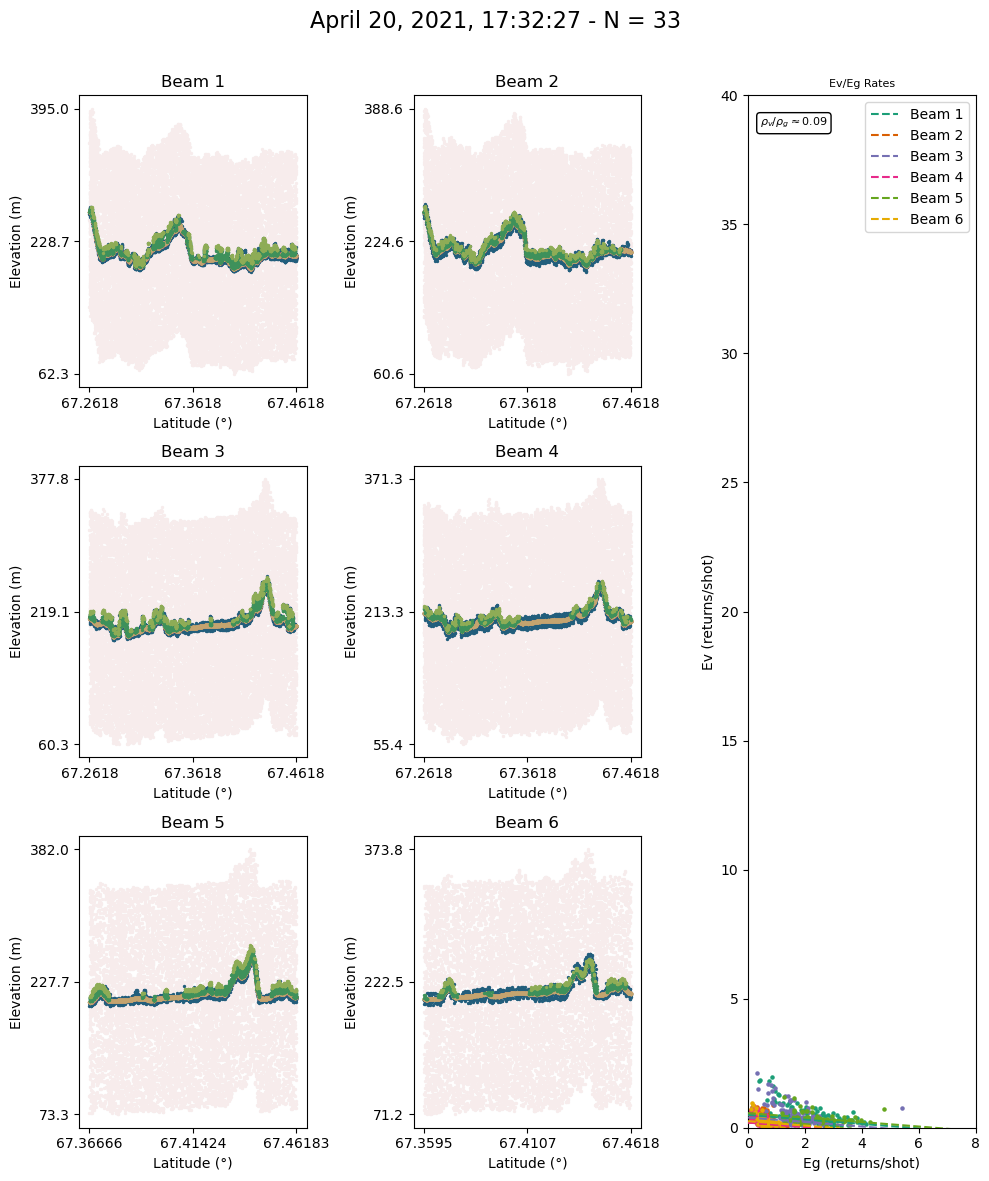

Beam 3 in file 34 has been skipped because of no data.
Beam 4 in file 34 has been skipped because of no data.
Beam 5 in file 34 has been skipped because of no data.
Beam 6 in file 34 has been skipped because of no data.
           Eg        Ev  Beam 1  Beam 2
0    1.015504  0.984496    True   False
1    0.934959  0.691057    True   False
2    1.270492  0.073770    True   False
3    1.446970  0.257576    True   False
4    1.765152  0.795455    True   False
..        ...       ...     ...     ...
300  0.598131  0.065421   False    True
301  0.235294  0.166667   False    True
302  0.425743  0.247525   False    True
303  0.320755  0.150943   False    True
304  0.578947  0.073684   False    True

[305 rows x 4 columns]


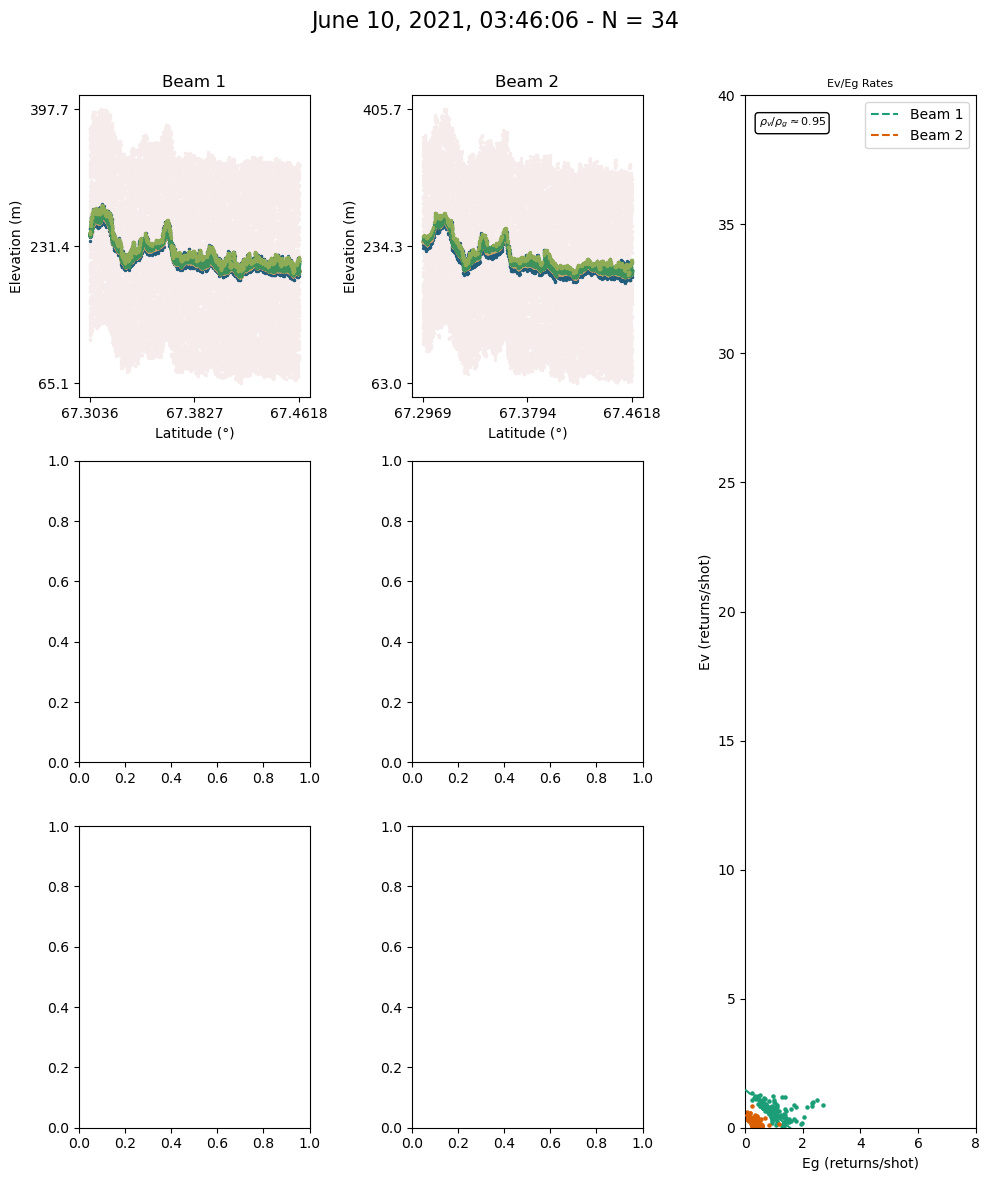

Beam 1 in file 35 has been skipped because of no data.
Beam 2 in file 35 has been skipped because of no data.
           Eg        Ev  Beam 3  Beam 4  Beam 5  Beam 6
0    0.663866  0.394958    True   False   False   False
1    0.705357  0.473214    True   False   False   False
2    0.821782  0.366337    True   False   False   False
3    0.551402  0.514019    True   False   False   False
4    0.773913  0.739130    True   False   False   False
..        ...       ...     ...     ...     ...     ...
397  0.265957  0.308511   False   False   False    True
398  0.234568  0.333333   False   False   False    True
399  0.243902  0.256098   False   False   False    True
400  0.382022  0.123596   False   False   False    True
401  0.215054  0.172043   False   False   False    True

[402 rows x 6 columns]


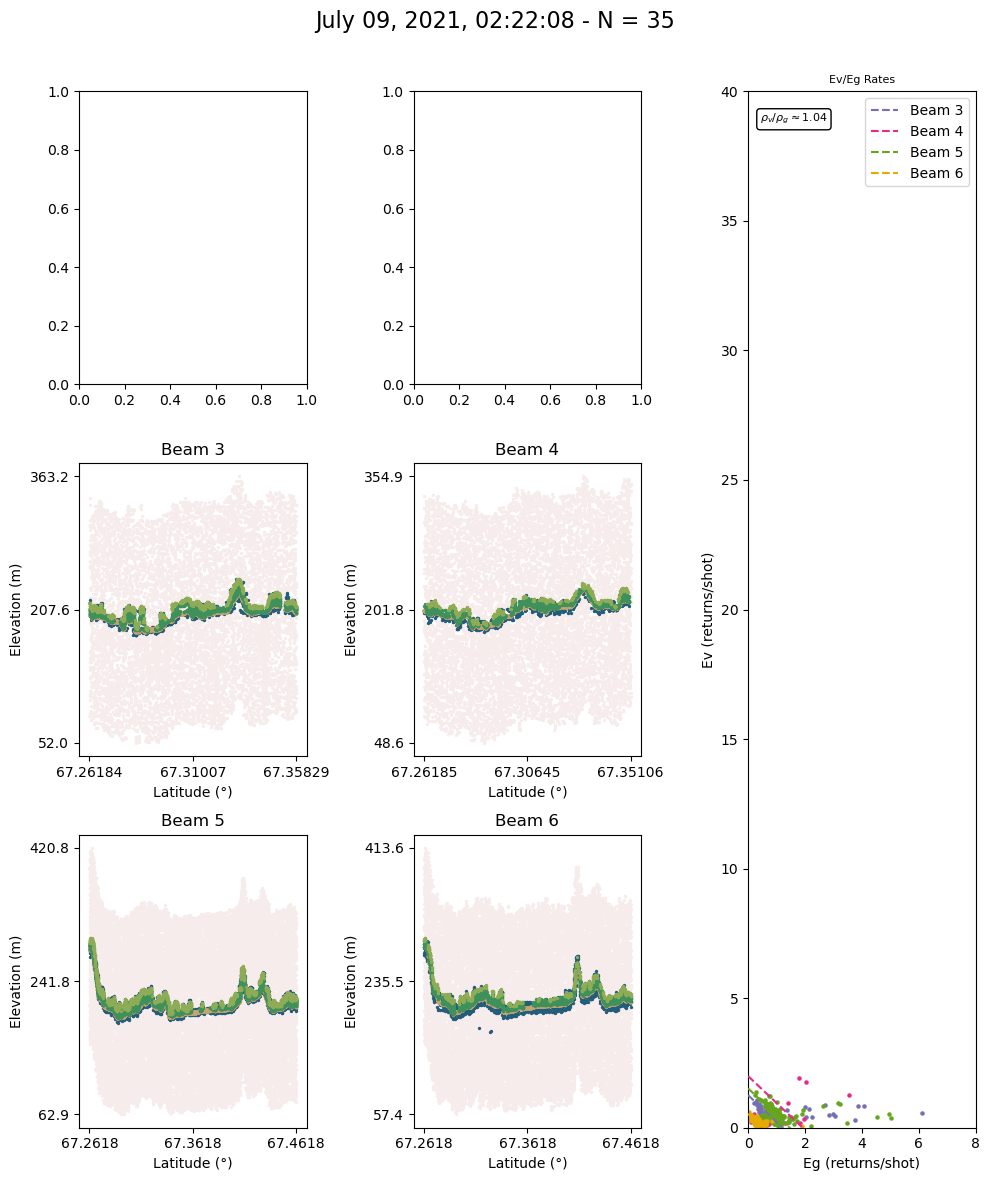

Beam 2 in file 36 has been skipped because of no data.
Beam 3 in file 36 has been skipped because of no data.
Beam 5 in file 36 has been skipped because of no data.
Beam 6 in file 36 has been skipped because of no data.
          Eg        Ev  Beam 1  Beam 4
0   0.029630  0.525926    True   False
1   0.437037  0.592593    True   False
2   0.128788  0.727273    True   False
3   0.115385  0.730769    True   False
4   3.637168  1.203540    True   False
5   0.141732  0.440945    True   False
6   0.170543  0.410853    True   False
7   0.240310  0.449612    True   False
8   0.099237  0.534351    True   False
9   0.182482  0.773723    True   False
10  0.007519  0.511278    True   False
11  0.000000  0.000000   False    True


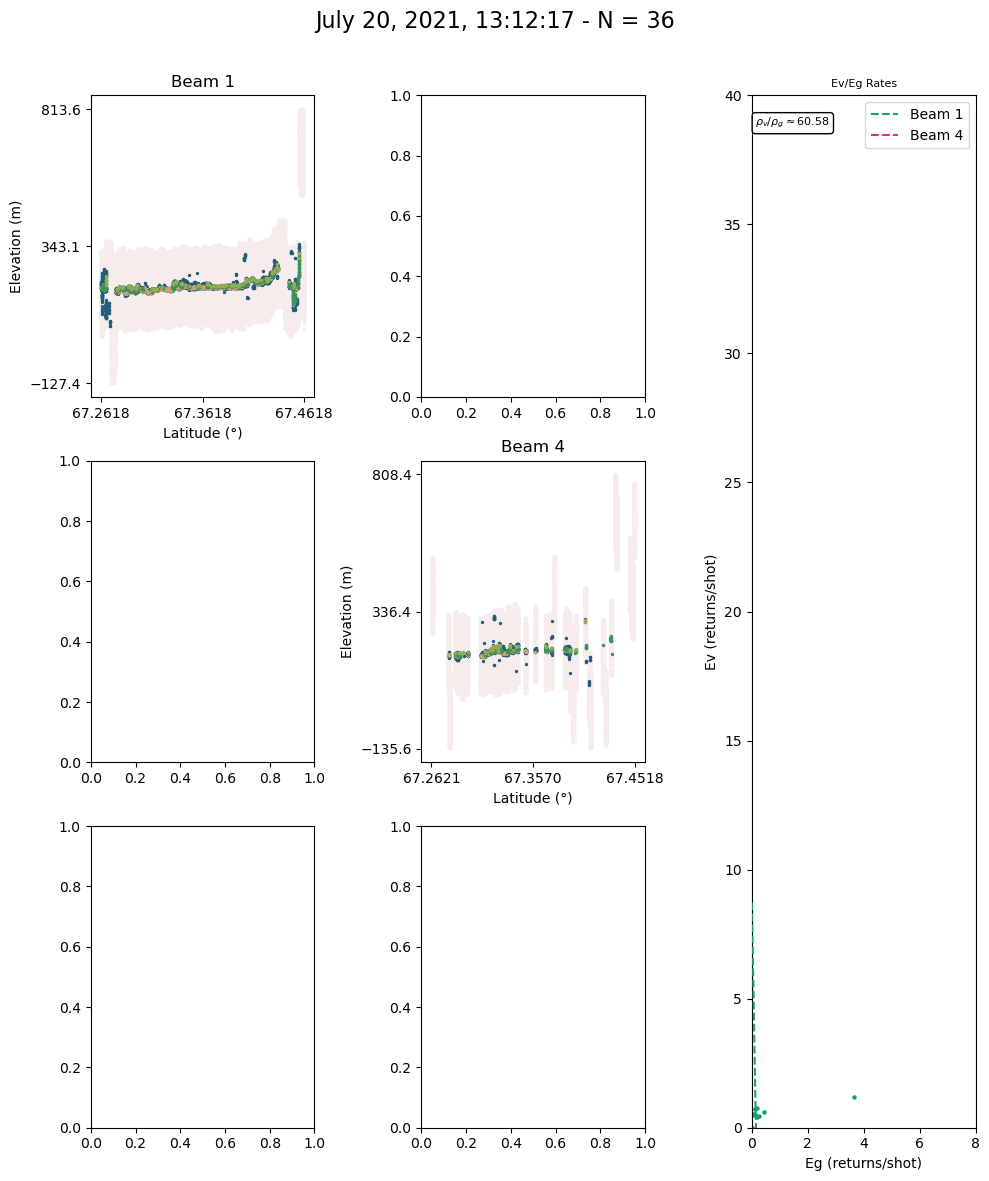

Beam 3 in file 37 has been skipped because of no data.
Beam 4 in file 37 has been skipped because of no data.
Beam 5 in file 37 has been skipped because of no data.
Beam 6 in file 37 has been skipped because of no data.
           Eg        Ev  Beam 1  Beam 2
0    1.070707  0.616162    True   False
1    1.276191  0.466667    True   False
2    1.289157  0.240964    True   False
3    0.435897  1.141026    True   False
4    3.508929  0.973214    True   False
..        ...       ...     ...     ...
240  0.738095  0.428571   False    True
241  0.540541  0.486486   False    True
242  0.529412  0.470588   False    True
243  0.700000  0.400000   False    True
244  1.596491  0.245614   False    True

[245 rows x 4 columns]


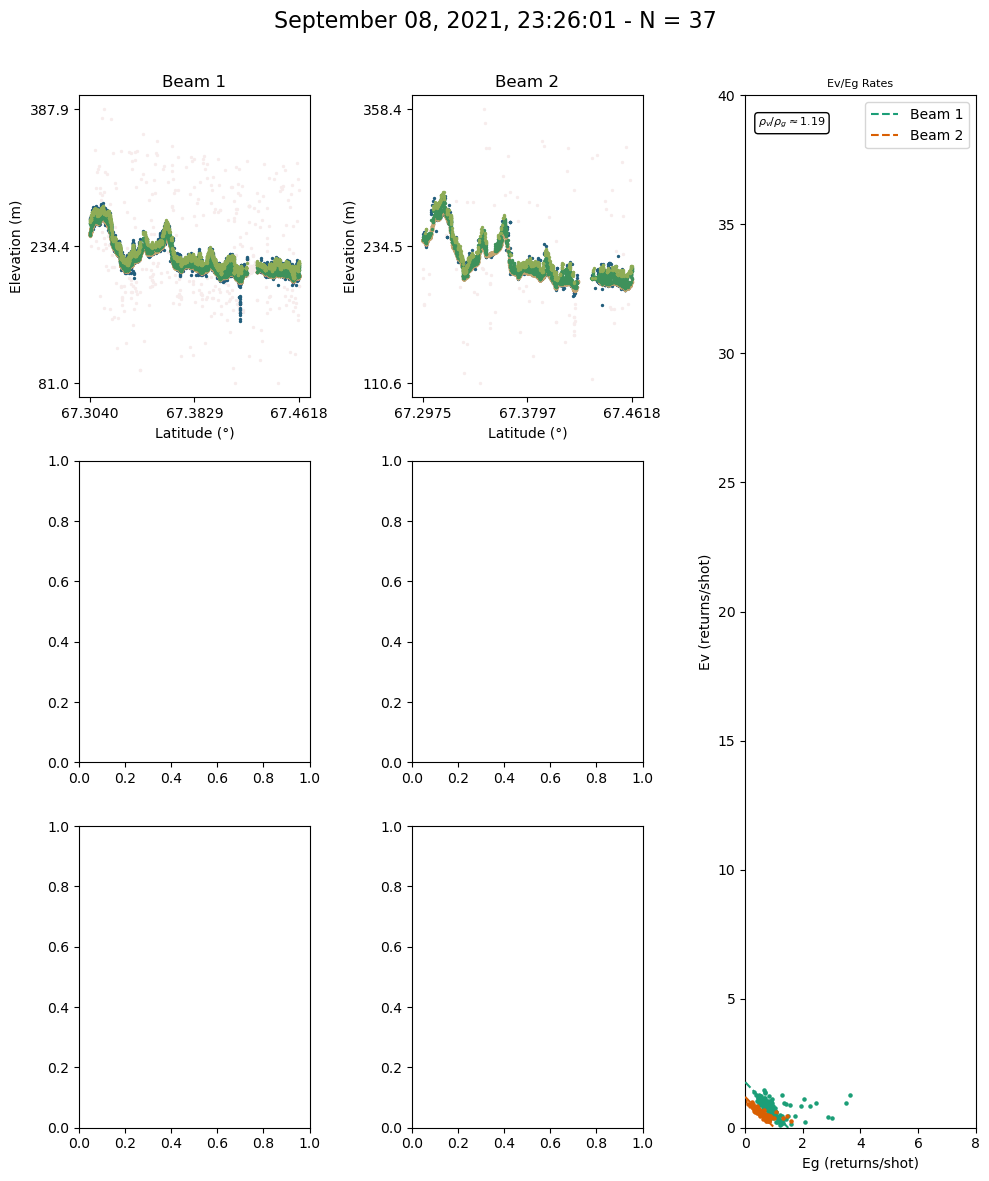

Beam 1 in file 38 has been skipped because of no data.
Beam 2 in file 38 has been skipped because of no data.
Beam 3 in file 38 has been skipped because of no data.
Beam 4 in file 38 has been skipped because of no data.
           Eg        Ev  Beam 5  Beam 6
0    0.685484  0.419355    True   False
1    0.351562  0.343750    True   False
2    0.480315  0.488189    True   False
3    0.169355  0.548387    True   False
4    0.856061  0.886364    True   False
..        ...       ...     ...     ...
183  0.184466  0.242718   False    True
184  0.027273  0.345455   False    True
185  0.192661  0.357798   False    True
186  0.260000  0.270000   False    True
187  0.156863  0.284314   False    True

[188 rows x 4 columns]


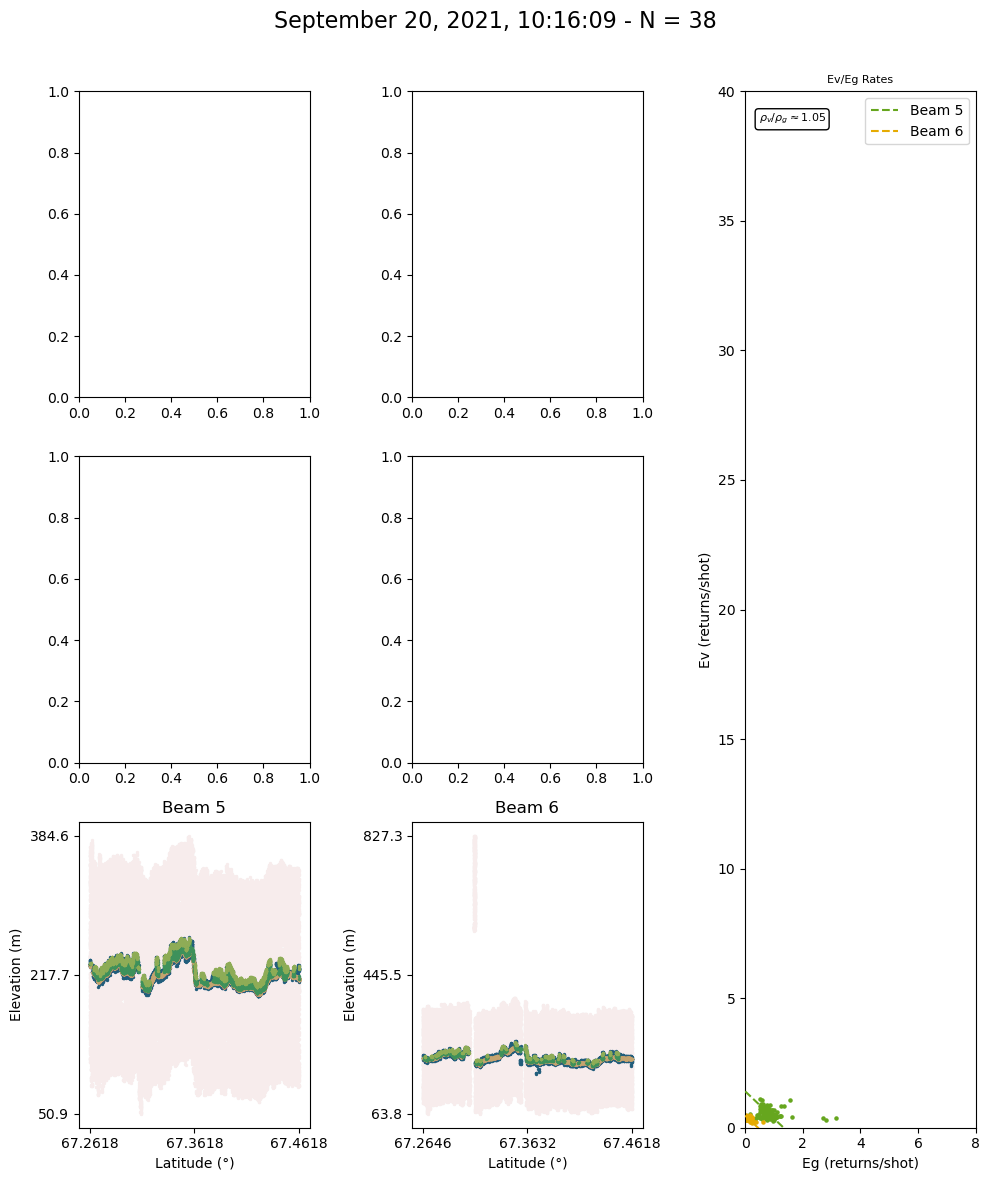

Beam 3 in file 39 has been skipped because of no data.
Beam 4 in file 39 has been skipped because of no data.
Beam 5 in file 39 has been skipped because of no data.
Beam 6 in file 39 has been skipped because of no data.
          Eg        Ev  Beam 1  Beam 2
0   0.806452  0.462366    True   False
1   0.767442  0.558140    True   False
2   1.157895  0.410526    True   False
3   1.115790  0.547368    True   False
4   0.806452  0.698925    True   False
..       ...       ...     ...     ...
74  0.600000  0.342857   False    True
75  0.413793  0.724138   False    True
76  0.961538  0.230769   False    True
77  2.235955  0.067416   False    True
78  1.760563  0.126761   False    True

[79 rows x 4 columns]


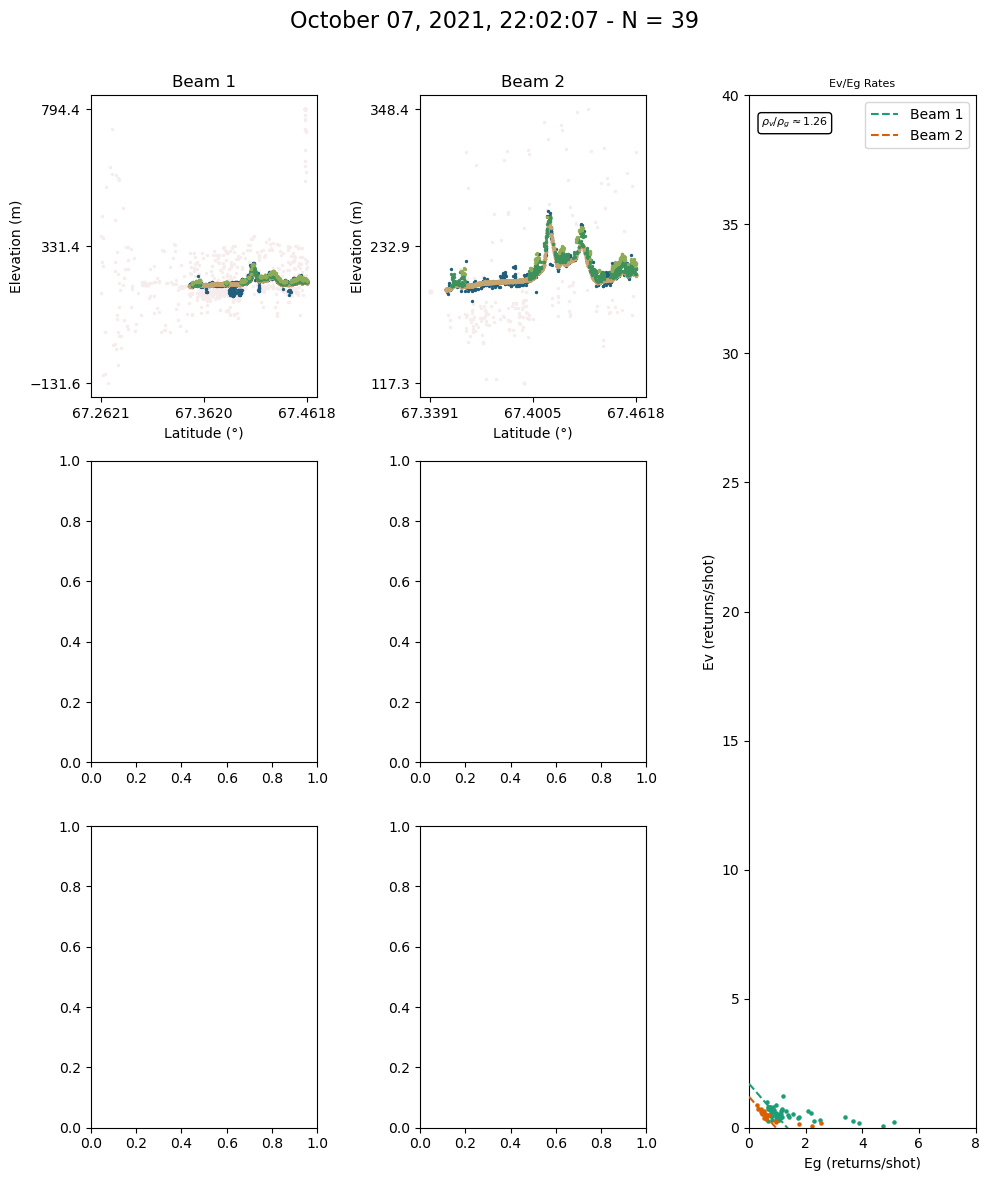

           Eg        Ev  Beam 1  Beam 2  Beam 3  Beam 4  Beam 5  Beam 6
0    5.850000  1.042857    True   False   False   False   False   False
1    5.887324  1.359155    True   False   False   False   False   False
2    5.893617  1.198582    True   False   False   False   False   False
3    5.257143  1.535714    True   False   False   False   False   False
4    5.241135  1.297872    True   False   False   False   False   False
..        ...       ...     ...     ...     ...     ...     ...     ...
795  0.806202  0.844961   False   False   False   False   False    True
796  1.483871  0.443548   False   False   False   False   False    True
797  1.291667  0.308333   False   False   False   False   False    True
798  0.758065  1.169355   False   False   False   False   False    True
799  0.806202  1.093023   False   False   False   False   False    True

[800 rows x 8 columns]


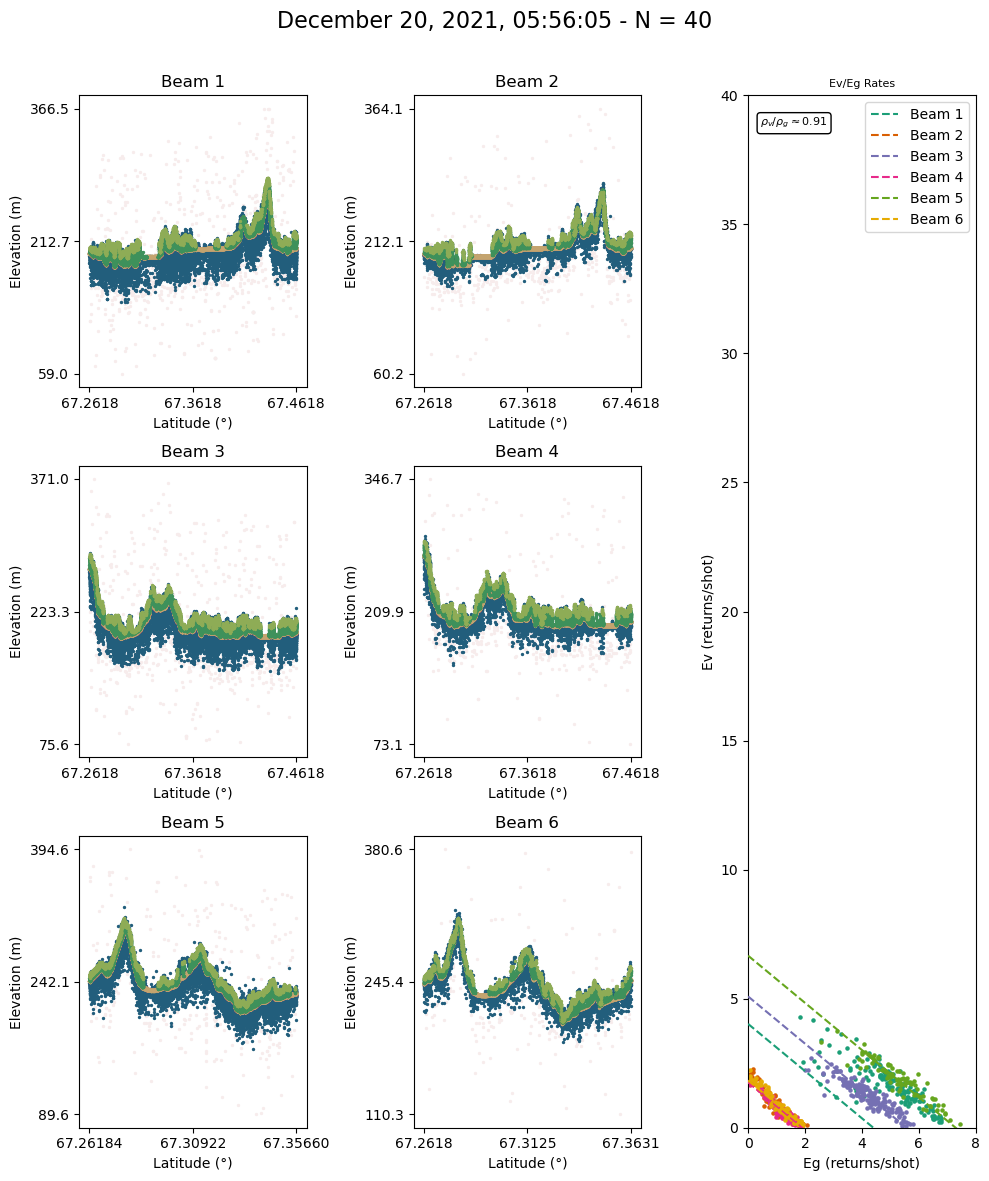

Beam 1 in file 41 has been skipped because of no data.
Beam 2 in file 41 has been skipped because of no data.
Beam 3 in file 41 has been skipped because of no data.
Beam 4 in file 41 has been skipped because of no data.
Beam 5 in file 41 has been skipped because of no data.
Beam 6 in file 41 has been skipped because of no data.
Empty DataFrame
Columns: [Eg, Ev]
Index: []
No beams have data in file 41, cannot regress.
Beam 1 in file 42 has been skipped because of no data.
Beam 2 in file 42 has been skipped because of no data.
           Eg        Ev  Beam 3  Beam 4  Beam 5  Beam 6
0    1.977444  0.729323    True   False   False   False
1    1.833333  0.942029    True   False   False   False
2    1.183824  1.536765    True   False   False   False
3    1.318841  1.028986    True   False   False   False
4    2.044118  0.455882    True   False   False   False
..        ...       ...     ...     ...     ...     ...
235  0.647059  0.729412   False   False   False    True
236  1.161290  0.1075

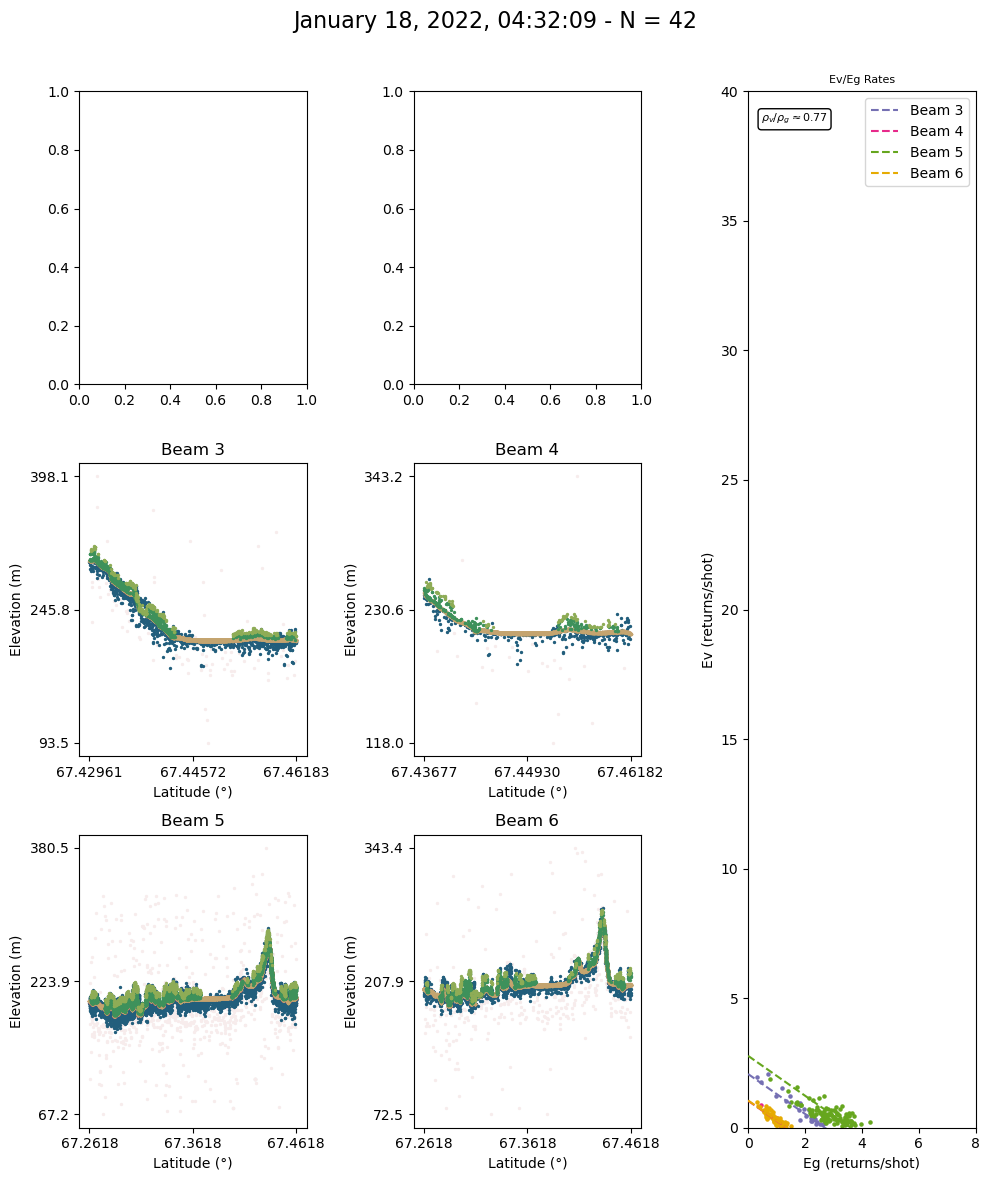

Beam 1 in file 43 has been skipped because of no data.
Beam 2 in file 43 has been skipped because of no data.
Beam 3 in file 43 has been skipped because of no data.
Beam 4 in file 43 has been skipped because of no data.
Beam 5 in file 43 has been skipped because of no data.
Beam 6 in file 43 has been skipped because of no data.
Empty DataFrame
Columns: [Eg, Ev]
Index: []
No beams have data in file 43, cannot regress.
Beam 1 in file 44 has been skipped because of no data.
Beam 2 in file 44 has been skipped because of no data.
Beam 3 in file 44 has been skipped because of no data.
Beam 4 in file 44 has been skipped because of no data.
Beam 5 in file 44 has been skipped because of no data.
Beam 6 in file 44 has been skipped because of no data.
Empty DataFrame
Columns: [Eg, Ev]
Index: []
No beams have data in file 44, cannot regress.
Beam 1 in file 45 has been skipped because of no data.
Beam 2 in file 45 has been skipped because of no data.
           Eg        Ev  Beam 3  Beam 4  Beam 5 

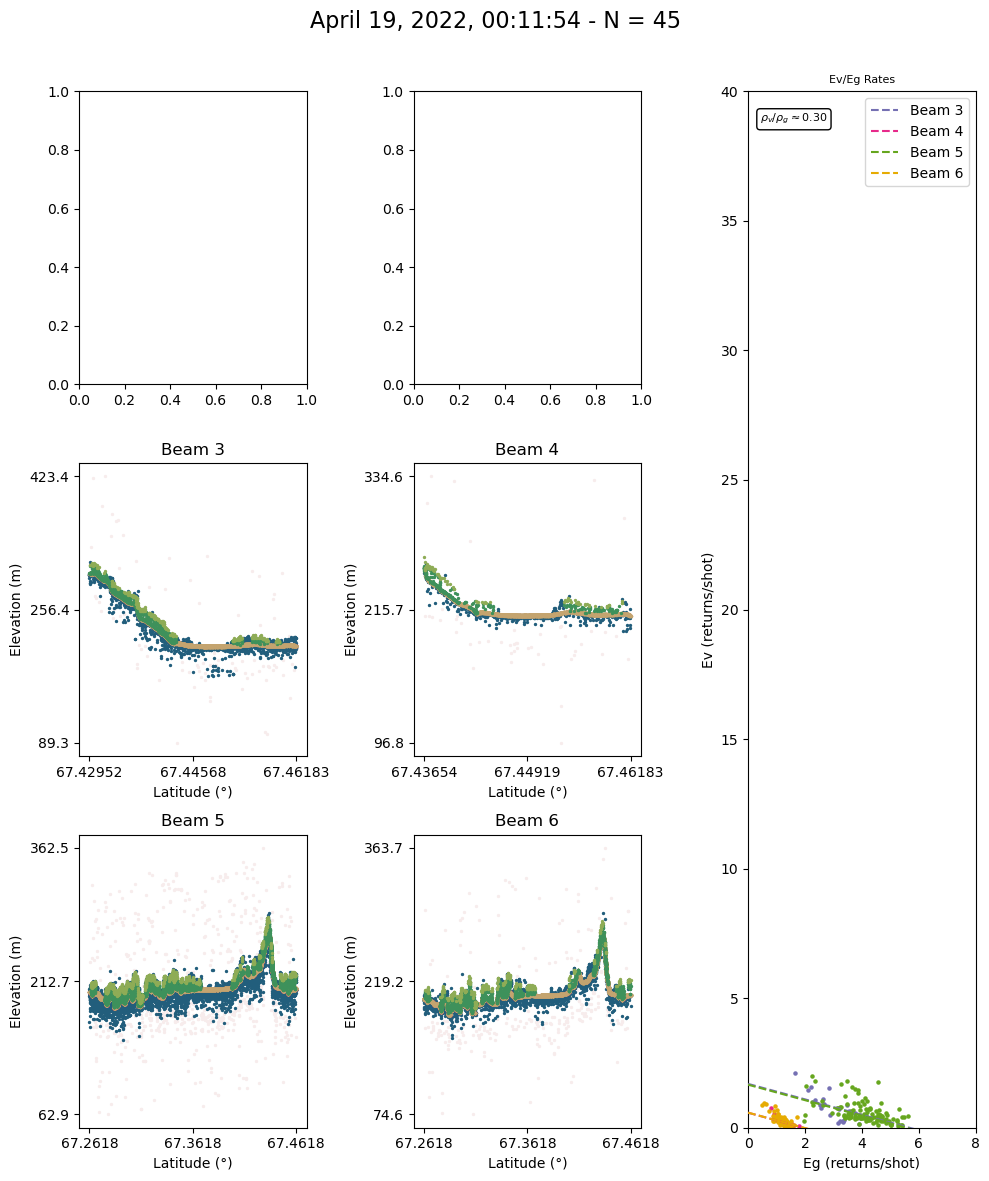

           Eg        Ev  Beam 1  Beam 2  Beam 3  Beam 4  Beam 5  Beam 6
0    0.812030  0.616541    True   False   False   False   False   False
1    0.992481  0.421053    True   False   False   False   False   False
2    0.775194  0.558140    True   False   False   False   False   False
3    0.882353  0.367647    True   False   False   False   False   False
4    0.731343  0.507463    True   False   False   False   False   False
..        ...       ...     ...     ...     ...     ...     ...     ...
179  0.553030  0.537879   False   False   False   False    True   False
180  0.953846  0.492308   False   False   False   False    True   False
181  0.711111  0.392593   False   False   False   False    True   False
182  0.068966  0.405172   False   False   False   False   False    True
183  0.108333  0.358333   False   False   False   False   False    True

[184 rows x 8 columns]


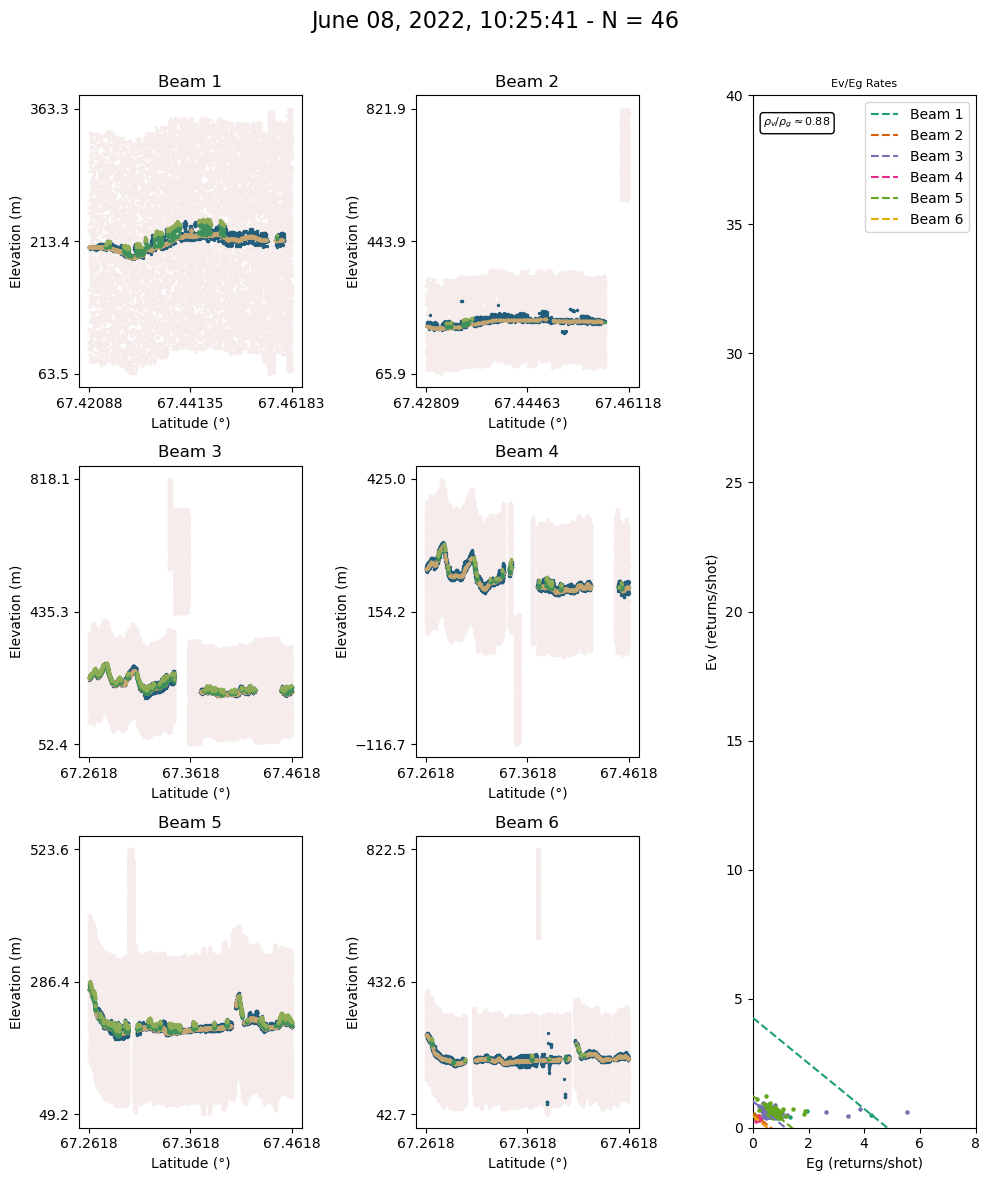

Beam 1 in file 47 has been skipped because of no data.
Beam 2 in file 47 has been skipped because of no data.
Beam 3 in file 47 has been skipped because of no data.
Beam 4 in file 47 has been skipped because of no data.
          Eg        Ev  Beam 5  Beam 6
0   1.834532  0.561151    True   False
1   0.659259  0.725926    True   False
2   0.876812  0.500000    True   False
3   0.699248  0.511278    True   False
4   0.674074  0.555556    True   False
5   0.848485  0.507576    True   False
6   0.469697  0.833333    True   False
7   0.533835  0.887218    True   False
8   0.701493  0.574627    True   False
9   0.445255  0.722628    True   False
10  0.625954  0.664122    True   False
11  0.859259  0.600000    True   False
12  0.875969  0.852713    True   False
13  2.942446  0.705036    True   False
14  2.685714  0.778571    True   False
15  4.050360  1.014388    True   False
16  1.350746  0.962687    True   False
17  2.482014  0.762590    True   False
18  0.365672  0.641791    True   False


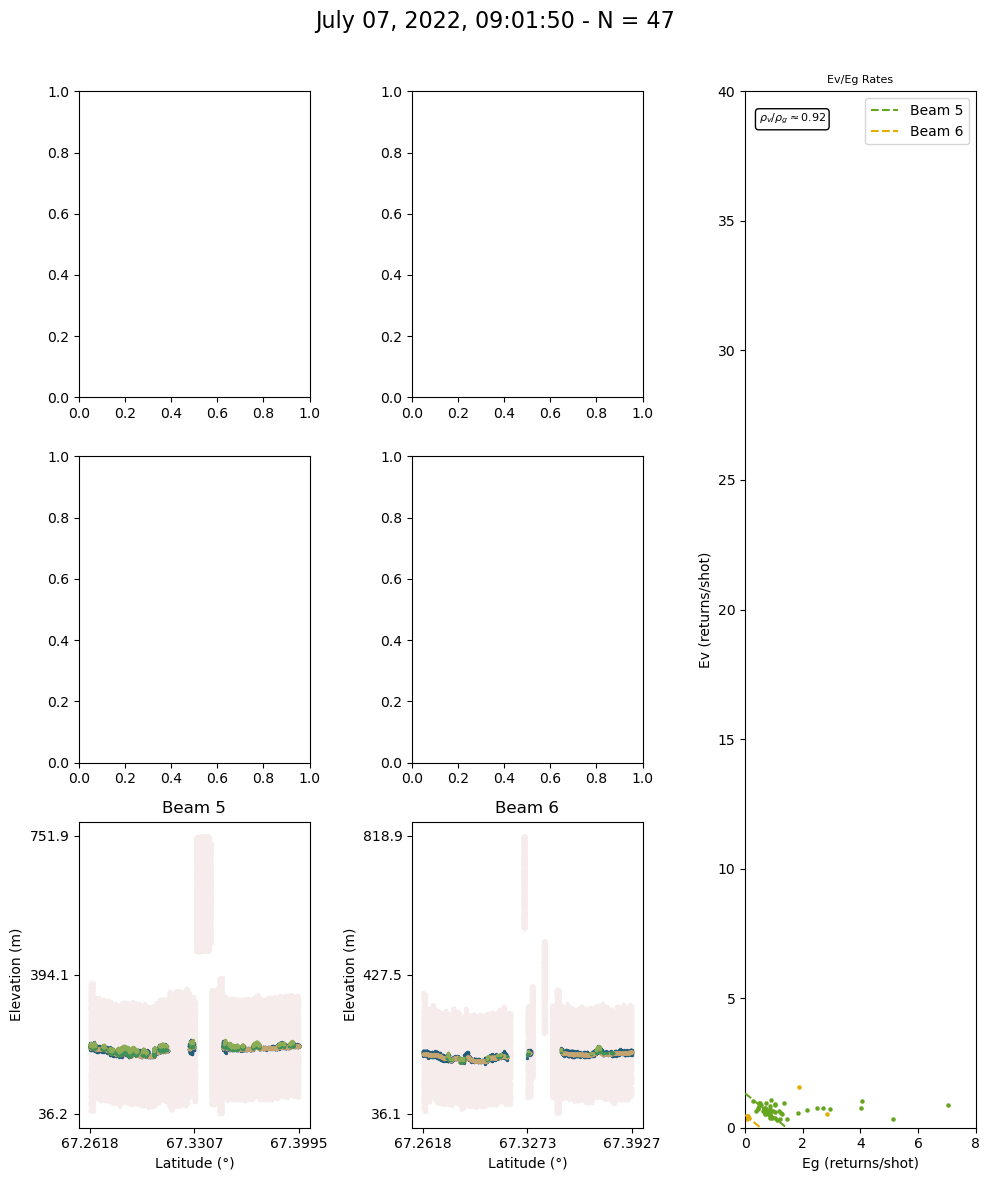

Beam 3 in file 48 has been skipped because of no data.
Beam 4 in file 48 has been skipped because of no data.
Beam 5 in file 48 has been skipped because of no data.
Beam 6 in file 48 has been skipped because of no data.
          Eg        Ev  Beam 1  Beam 2
0   2.030928  0.309278    True   False
1   3.254386  0.131579    True   False
2   0.128571  0.714286    True   False
3   0.273973  0.616438    True   False
4   0.671642  0.522388    True   False
5   0.350649  0.519481    True   False
6   0.768293  0.451219    True   False
7   0.421053  0.486842    True   False
8   0.304348  0.623188    True   False
9   0.218182  0.745455    True   False
10  0.626667  0.320000    True   False
11  0.500000  0.500000    True   False
12  0.324324  0.662162    True   False
13  0.884615  0.256410    True   False
14  0.542169  0.361446    True   False
15  0.546667  0.146667    True   False
16  0.414286  0.514286    True   False
17  0.684211  0.144737    True   False
18  0.736264  0.131868    True   False


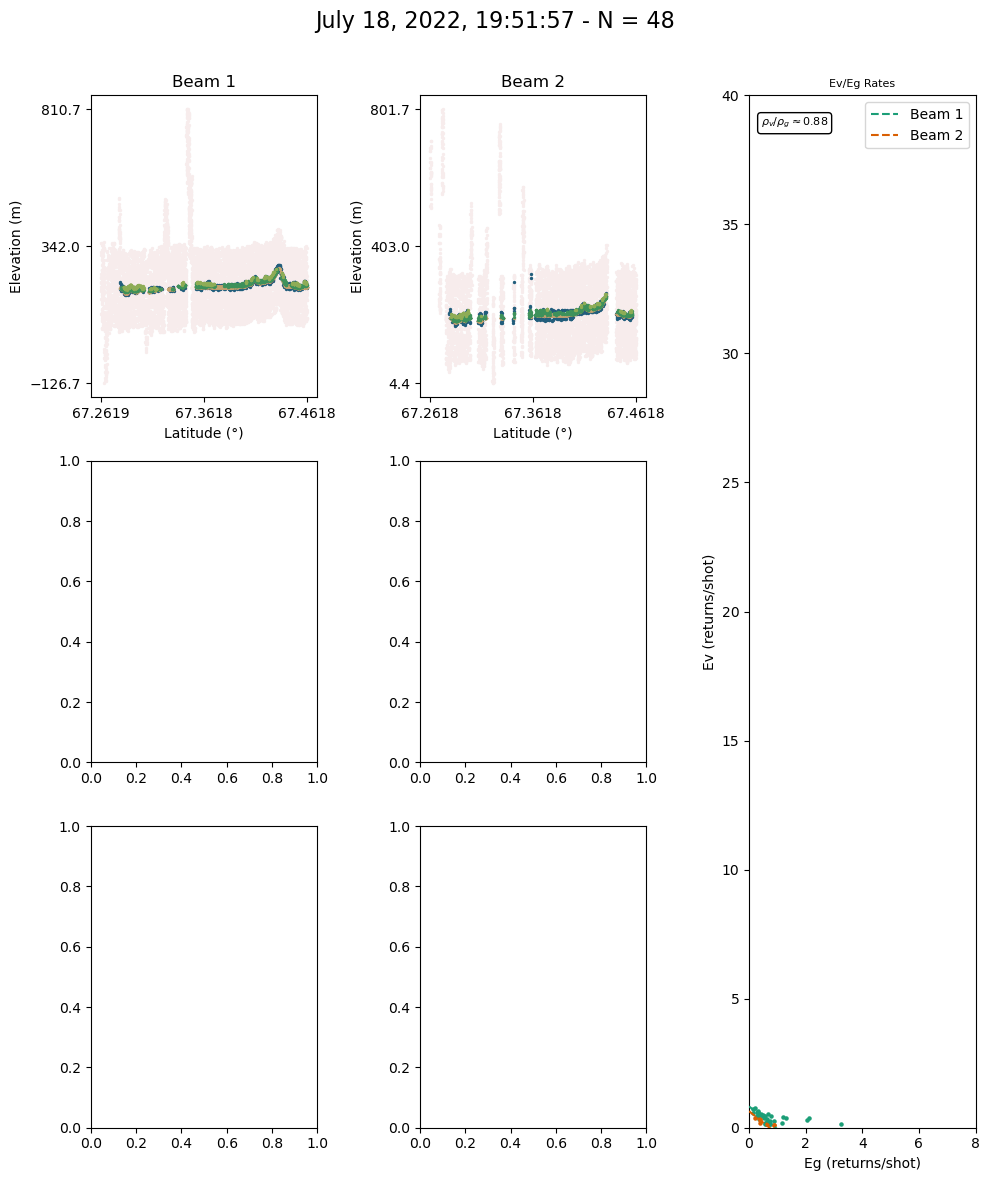

Beam 1 in file 49 has been skipped because of no data.
Beam 2 in file 49 has been skipped because of no data.
Beam 3 in file 49 has been skipped because of no data.
Beam 4 in file 49 has been skipped because of no data.
Beam 5 in file 49 has been skipped because of no data.
Beam 6 in file 49 has been skipped because of no data.
Empty DataFrame
Columns: [Eg, Ev]
Index: []
No beams have data in file 49, cannot regress.
Beam 1 in file 50 has been skipped because of no data.
Beam 2 in file 50 has been skipped because of no data.
Beam 3 in file 50 has been skipped because of no data.
Beam 4 in file 50 has been skipped because of no data.
Beam 5 in file 50 has been skipped because of no data.
Beam 6 in file 50 has been skipped because of no data.
Empty DataFrame
Columns: [Eg, Ev]
Index: []
No beams have data in file 50, cannot regress.
Beam 1 in file 51 has been skipped because of no data.
Beam 2 in file 51 has been skipped because of no data.
Beam 3 in file 51 has been skipped because of no

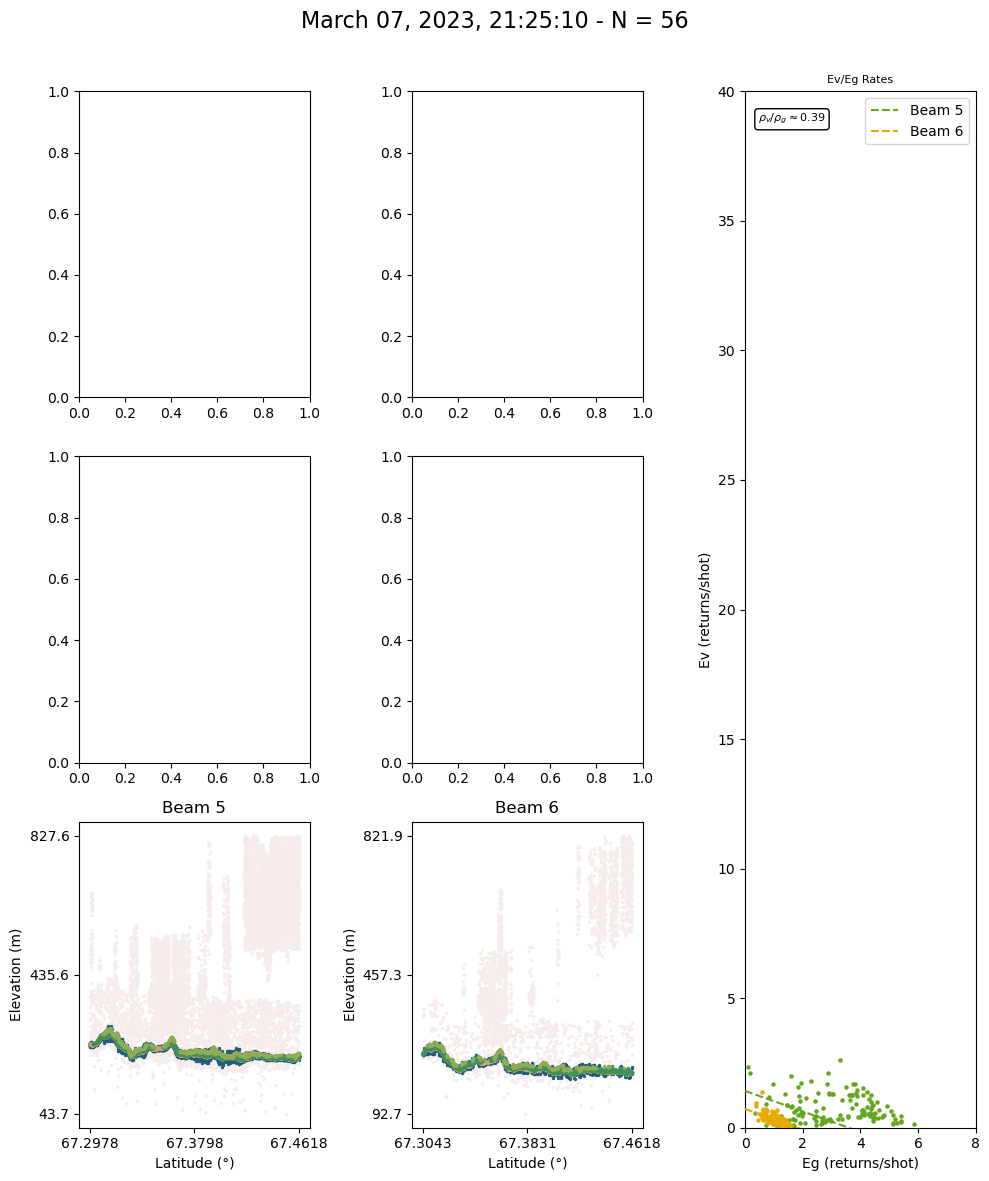

Beam 3 in file 57 has been skipped because of no data.
Beam 4 in file 57 has been skipped because of no data.
Beam 5 in file 57 has been skipped because of no data.
Beam 6 in file 57 has been skipped because of no data.
           Eg        Ev  Beam 1  Beam 2
0    4.342857  1.878571    True   False
1    5.007092  1.702128    True   False
2    5.580420  1.279720    True   False
3    5.126760  1.281690    True   False
4    5.949275  1.036232    True   False
..        ...       ...     ...     ...
268  1.051095  0.430657   False    True
269  1.400000  0.221429   False    True
270  1.407143  0.400000   False    True
271  1.128571  0.578571   False    True
272  1.328571  0.257143   False    True

[273 rows x 4 columns]


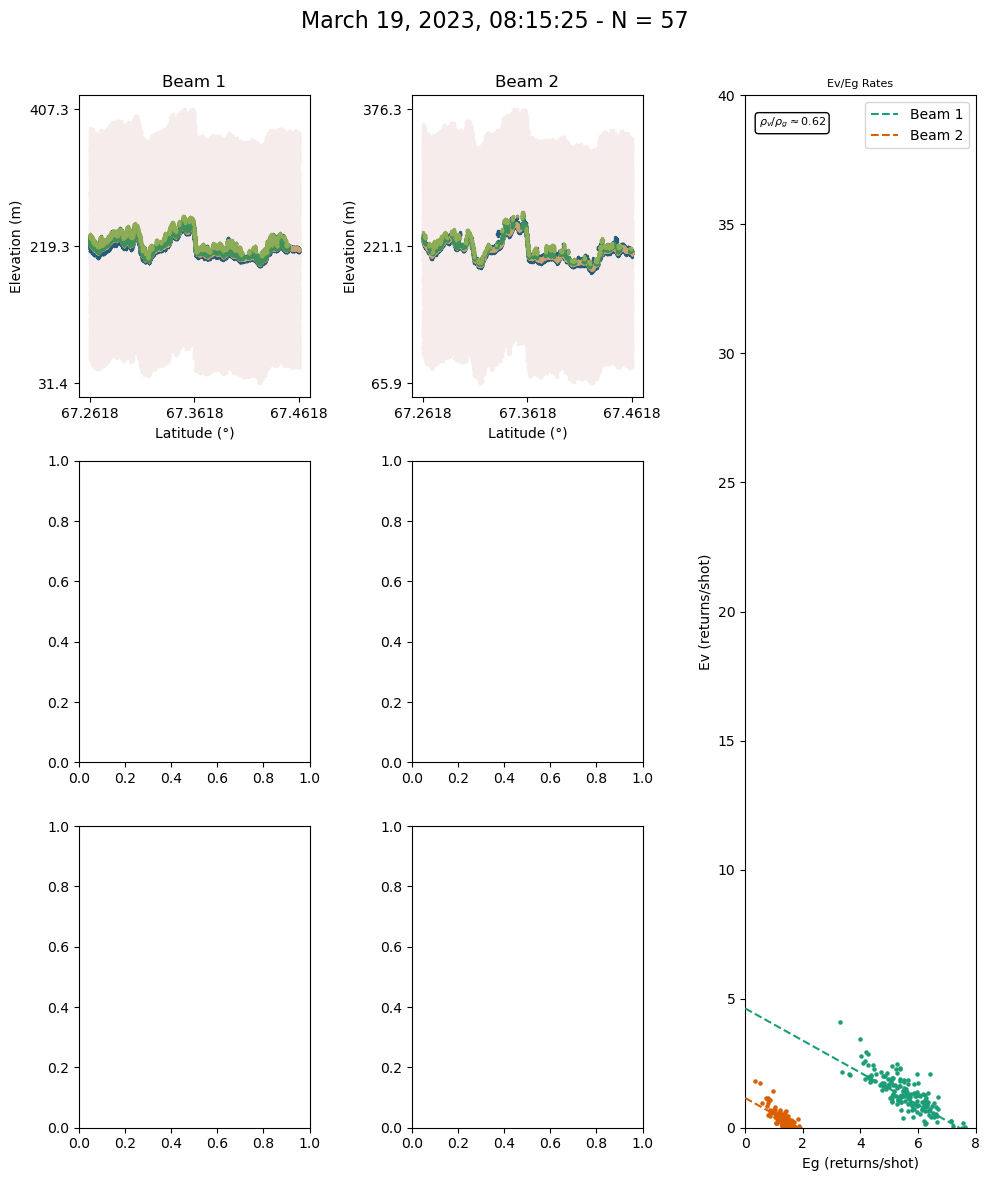

Beam 3 in file 58 has been skipped because of no data.
Beam 4 in file 58 has been skipped because of no data.
Beam 5 in file 58 has been skipped because of no data.
Beam 6 in file 58 has been skipped because of no data.
           Eg        Ev  Beam 1  Beam 2
0    5.581560  0.177305    True   False
1    3.185714  0.771429    True   False
2    2.906475  0.856115    True   False
3    3.205674  0.957447    True   False
4    1.602837  2.177305    True   False
..        ...       ...     ...     ...
114  0.578947  0.824561   False    True
115  0.600000  0.485714   False    True
116  0.659091  0.318182   False    True
117  0.393939  0.575758   False    True
118  0.545455  0.681818   False    True

[119 rows x 4 columns]


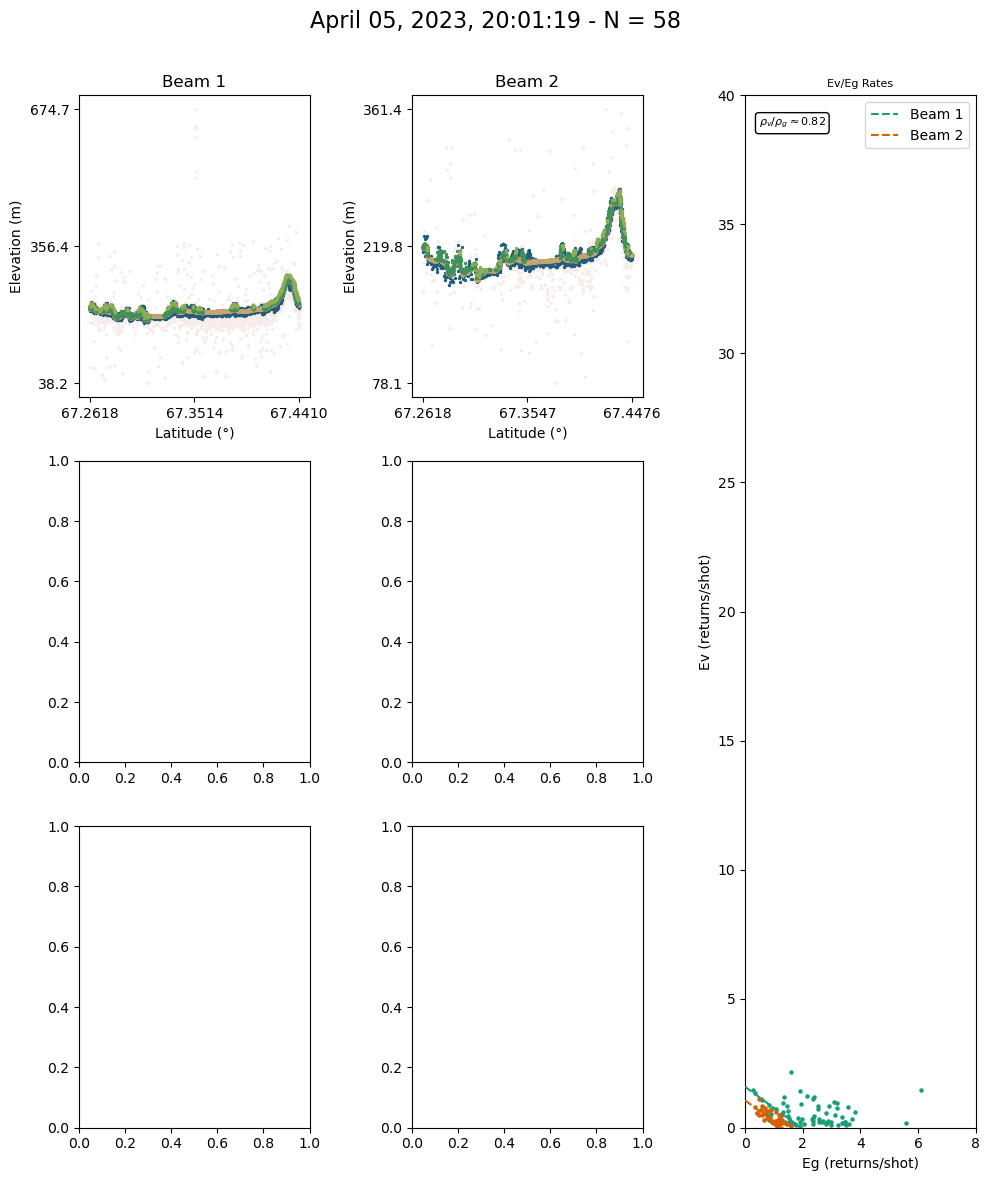

Beam 1 in file 59 has been skipped because of no data.
Beam 2 in file 59 has been skipped because of no data.
Beam 3 in file 59 has been skipped because of no data.
Beam 4 in file 59 has been skipped because of no data.
Beam 5 in file 59 has been skipped because of no data.
Beam 6 in file 59 has been skipped because of no data.
Empty DataFrame
Columns: [Eg, Ev]
Index: []
No beams have data in file 59, cannot regress.
Beam 1 in file 60 has been skipped because of no data.
Beam 2 in file 60 has been skipped because of no data.
Beam 3 in file 60 has been skipped because of no data.
Beam 4 in file 60 has been skipped because of no data.
Beam 5 in file 60 has been skipped because of no data.
Beam 6 in file 60 has been skipped because of no data.
Empty DataFrame
Columns: [Eg, Ev]
Index: []
No beams have data in file 60, cannot regress.
Beam 1 in file 61 has been skipped because of no data.
Beam 2 in file 61 has been skipped because of no data.
Beam 3 in file 61 has been skipped because of no

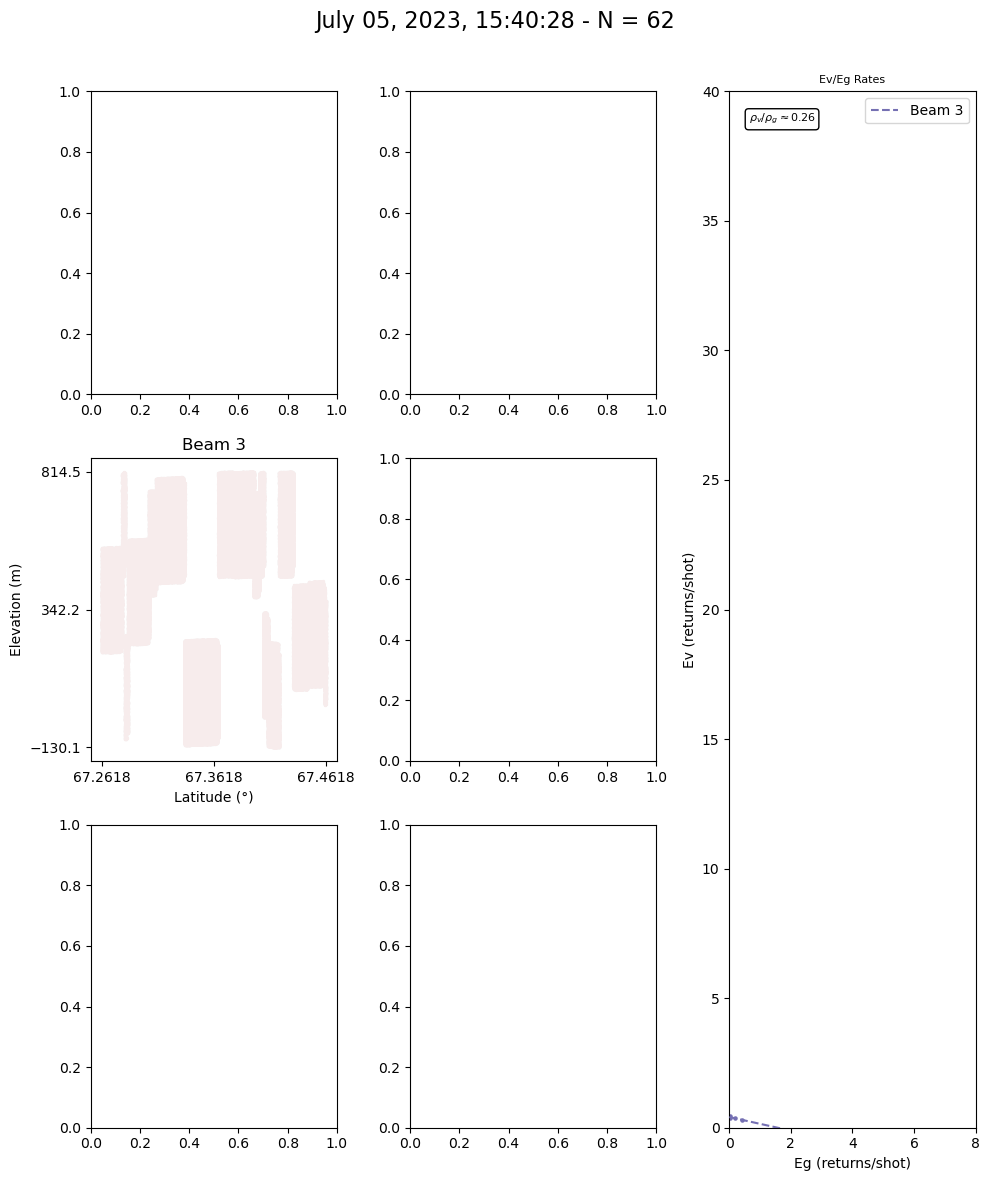

Beam 1 in file 63 has been skipped because of no data.
Beam 2 in file 63 has been skipped because of no data.
Beam 3 in file 63 has been skipped because of no data.
Beam 4 in file 63 has been skipped because of no data.
          Eg        Ev  Beam 5  Beam 6
0   0.121739  0.391304    True   False
1   0.763780  0.212598    True   False
2   0.393443  0.418033    True   False
3   0.723077  0.384615    True   False
4   0.403226  0.709677    True   False
5   0.480916  0.679389    True   False
6   0.648855  0.488550    True   False
7   0.439024  0.715447    True   False
8   0.419355  0.532258    True   False
9   0.436508  0.365079    True   False
10  0.427419  0.508065    True   False
11  1.709924  0.610687    True   False
12  0.096154  0.269231   False    True
13  0.200000  0.220000   False    True
14  0.176471  0.254902   False    True
15  0.000000  0.333333   False    True
16  0.152174  0.195652   False    True
17  0.076087  0.326087   False    True
18  0.096154  0.211538   False    True


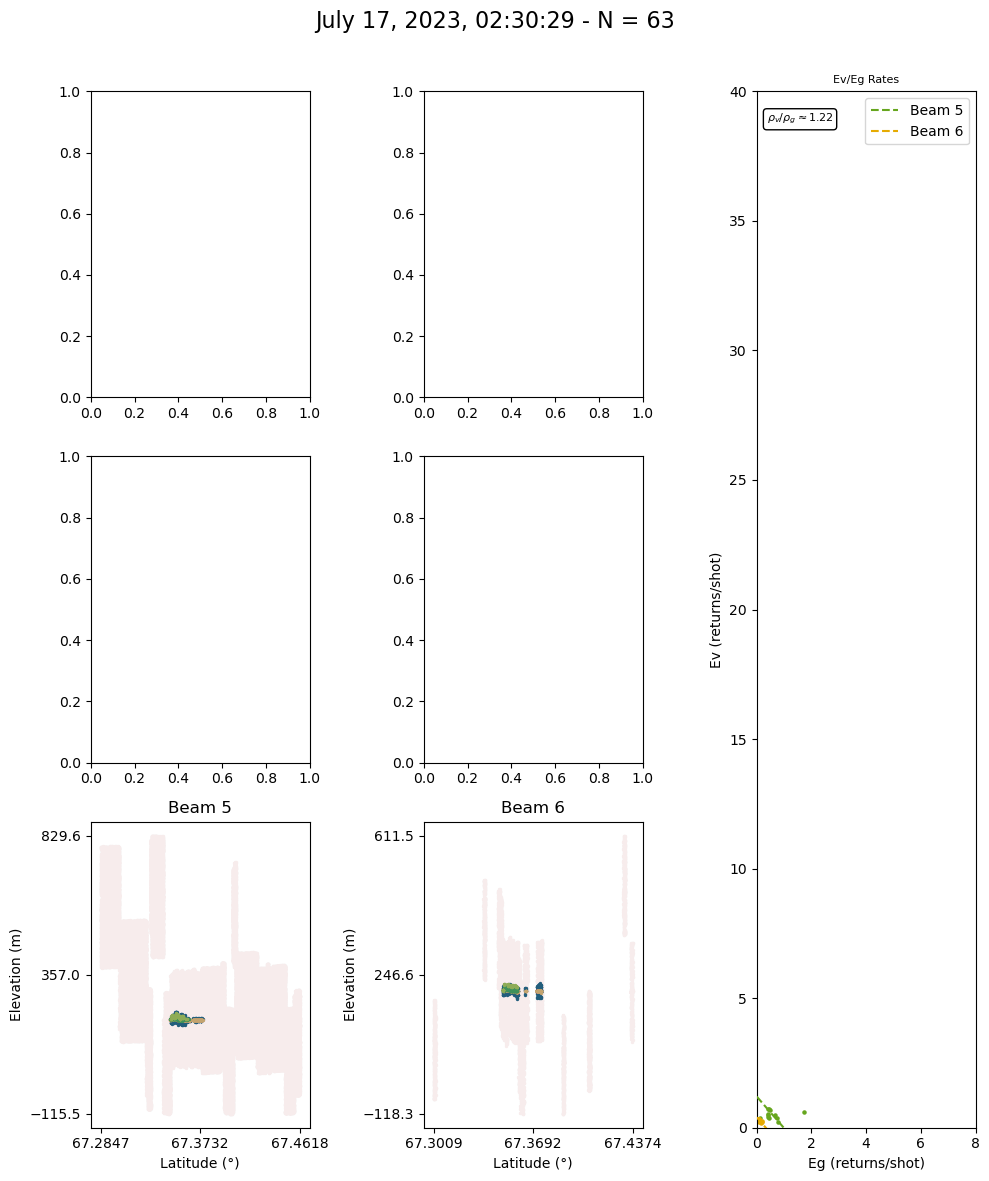

Beam 1 in file 64 has been skipped because of no data.
Beam 2 in file 64 has been skipped because of no data.
Beam 3 in file 64 has been skipped because of no data.
Beam 4 in file 64 has been skipped because of no data.
          Eg        Ev  Beam 5  Beam 6
0   0.772358  0.422764    True   False
1   0.822222  0.511111    True   False
2   0.944000  0.432000    True   False
3   0.833333  0.452381    True   False
4   0.780488  0.365854    True   False
5   1.177419  0.314516    True   False
6   0.759690  0.271318    True   False
7   0.906250  0.312500    True   False
8   1.038760  0.434109    True   False
9   1.119403  0.701493    True   False
10  0.862595  0.824427    True   False
11  0.900763  0.793893    True   False
12  1.029630  0.318519    True   False
13  0.607692  0.353846    True   False
14  0.610687  0.366412    True   False
15  0.233333  0.200000   False    True
16  0.008929  0.366071   False    True


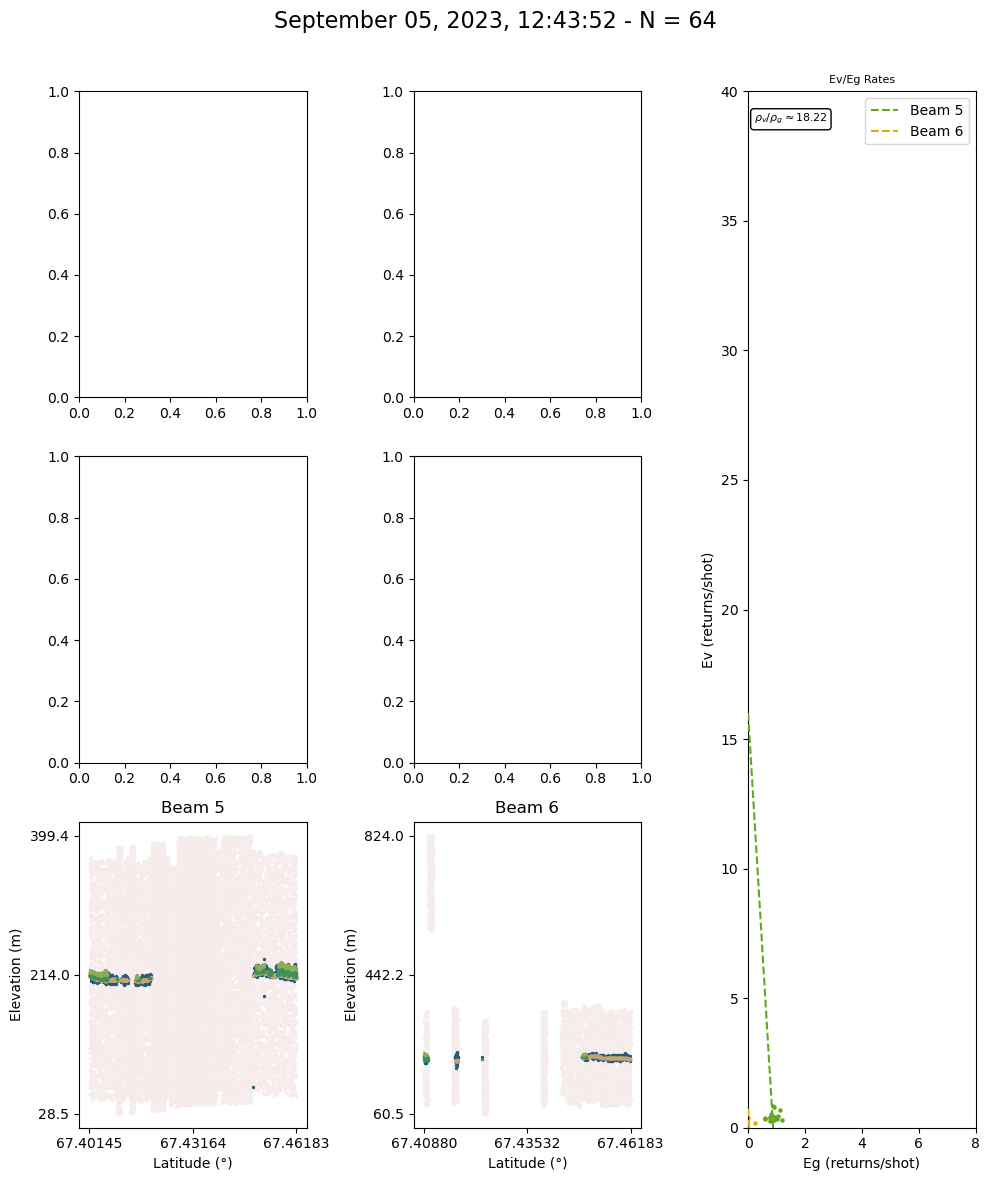

Beam 3 in file 65 has been skipped because of no data.
Beam 4 in file 65 has been skipped because of no data.
Beam 5 in file 65 has been skipped because of no data.
Beam 6 in file 65 has been skipped because of no data.
         Eg        Ev  Beam 1  Beam 2
0  0.633803  0.436620    True   False
1  0.876923  0.384615    True   False
2  0.555556  0.650794    True   False
3  0.688525  0.655738    True   False
4  0.560000  0.640000   False    True
5  0.581395  0.534884   False    True


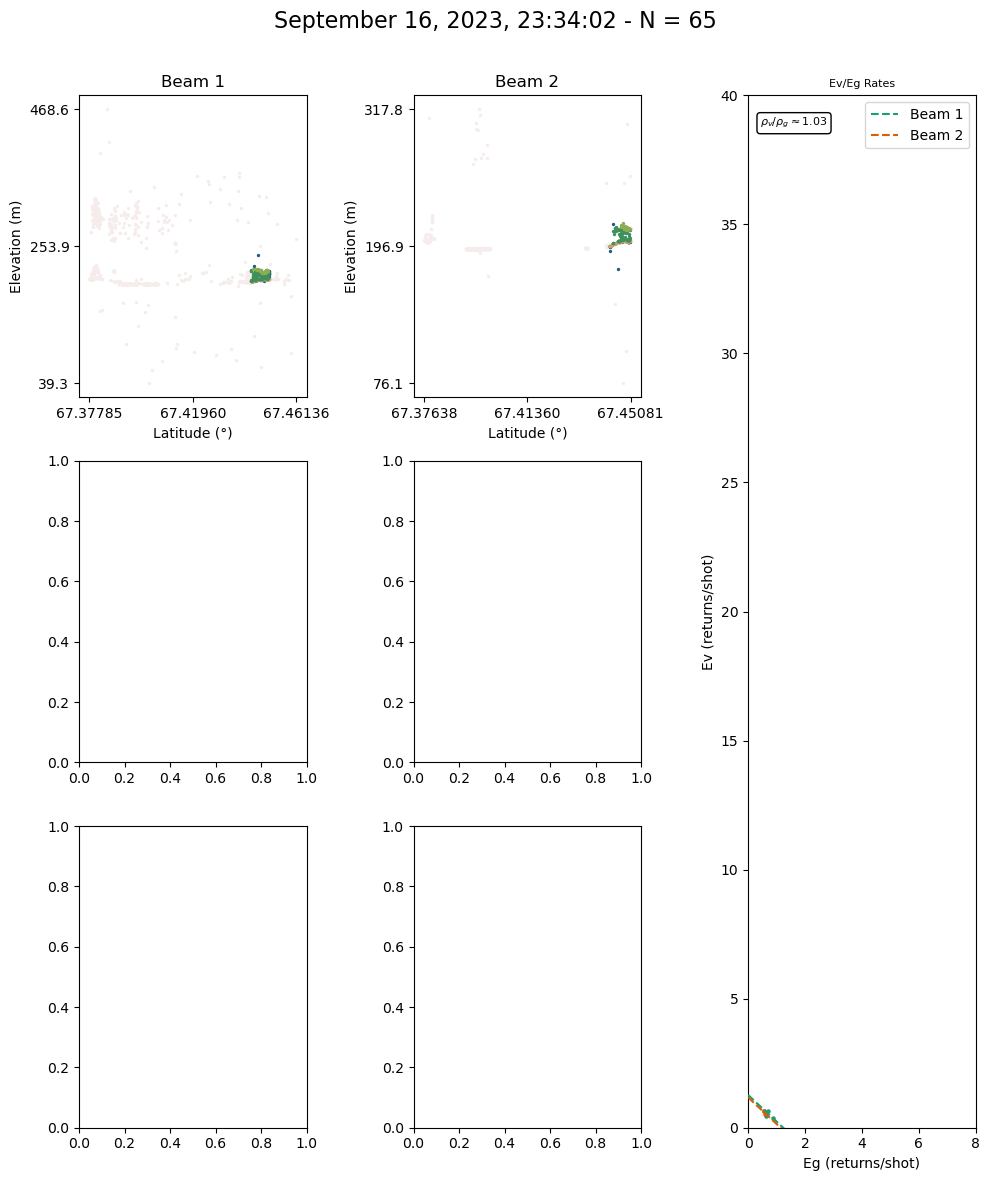

Beam 2 in file 66 has been skipped because of no data.
Beam 3 in file 66 has been skipped because of no data.
Beam 4 in file 66 has been skipped because of no data.
Beam 5 in file 66 has been skipped because of no data.
Beam 6 in file 66 has been skipped because of no data.
         Eg        Ev  Beam 1
0  0.178295  0.170543    True
1  0.318841  0.072464    True


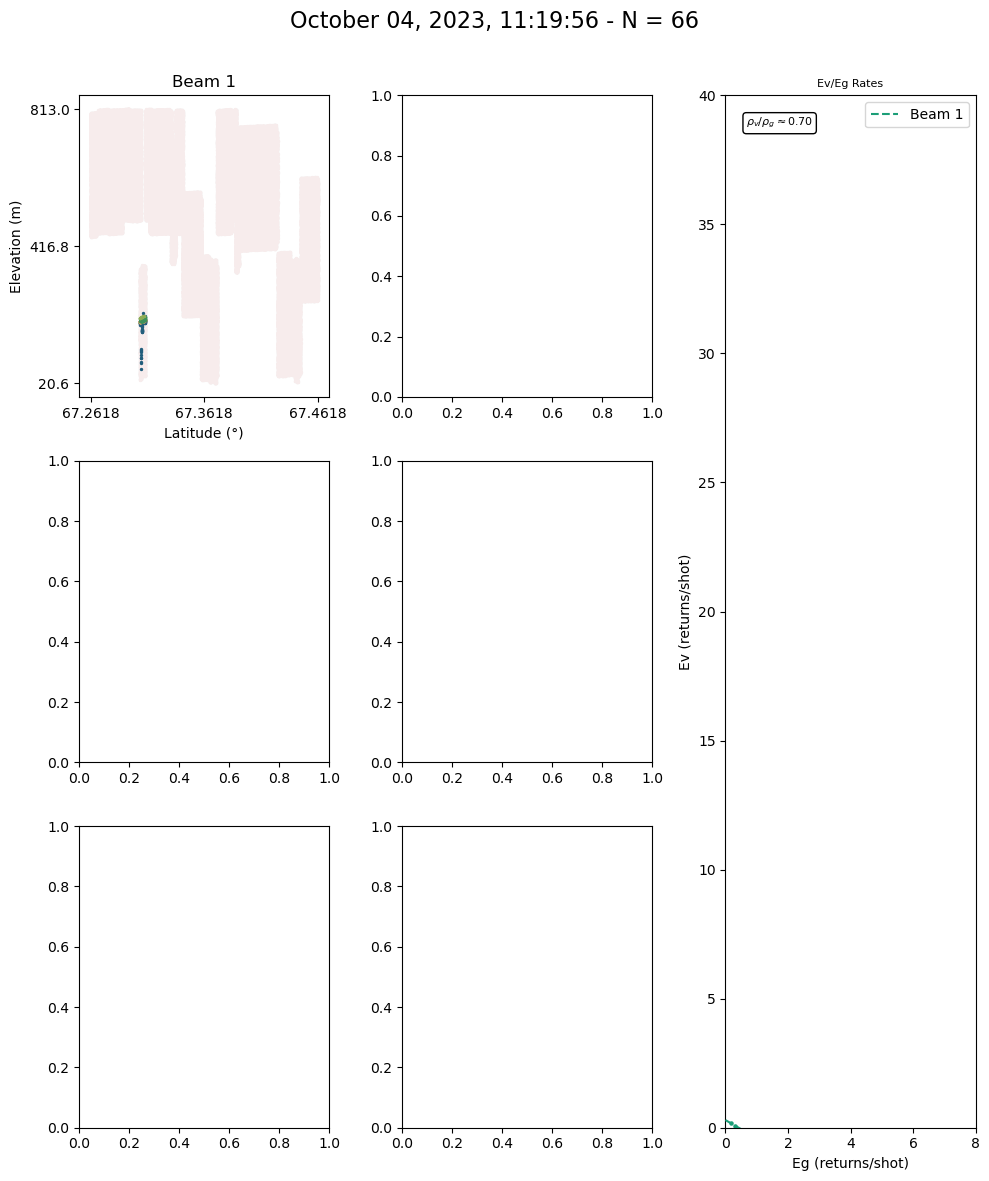

Beam 1 in file 67 has been skipped because of no data.
Beam 2 in file 67 has been skipped because of no data.
Beam 3 in file 67 has been skipped because of no data.
Beam 4 in file 67 has been skipped because of no data.
Beam 5 in file 67 has been skipped because of no data.
Beam 6 in file 67 has been skipped because of no data.
Empty DataFrame
Columns: [Eg, Ev]
Index: []
No beams have data in file 67, cannot regress.


In [30]:
dirpath = '../data_store/data/sodankyla_full/'

all_ATL03, all_ATL08 = track_pairs(dirpath)
N = len(all_ATL03)

sodankyla_coords = (26.634154, 67.361833)

for i in range(N):
    data = pvpg_parallel(all_ATL03[i], all_ATL08[i], coords=sodankyla_coords, width=.1,height=.1,\
                         graph_detail=2, loss='arctan',file_index=i, keep_flagged=1, opsys='bad',f_scale=.1)

# Filtering out too few points

In [16]:
dirpath = '../data_store/data/sodankyla_full/'

all_ATL03, all_ATL08 = track_pairs(dirpath)
N = len(all_ATL03)

sodankyla_coords = (26.634154, 67.361833)

for i in [18]:
    data = pvpg_parallel(all_ATL03[i], all_ATL08[i], coords=sodankyla_coords, width=.1,height=.1,\
                         graph_detail=2, loss='arctan',file_index=i, keep_flagged=1, opsys='bad',f_scale=.1)

Beam 1 in file 18 has insufficient data.
Beam 2 in file 18 has insufficient data.
Beam 3 in file 18 has insufficient data.
Beam 4 in file 18 has insufficient data.
Beam 5 in file 18 has insufficient data.
Beam 6 in file 18 has insufficient data.
No beams have data in file 18, cannot regress.
